Reviewing file: ../data/Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv

Basic Info:
Shape: (287196, 10)

Columns and Data Types:
1. month (dtype: object)
2. town (dtype: object)
3. flat_type (dtype: object)
4. block (dtype: object)
5. street_name (dtype: object)
6. storey_range (dtype: object)
7. floor_area_sqm (dtype: float64)
8. flat_model (dtype: object)
9. lease_commence_date (dtype: int64)
10. resale_price (dtype: int64)

First 5 Rows:
     month        town flat_type block       street_name storey_range  \
0  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
1  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     04 TO 06   
2  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
3  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     07 TO 09   
4  1990-01  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     04 TO 06   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  
0            31.0        IMPROV

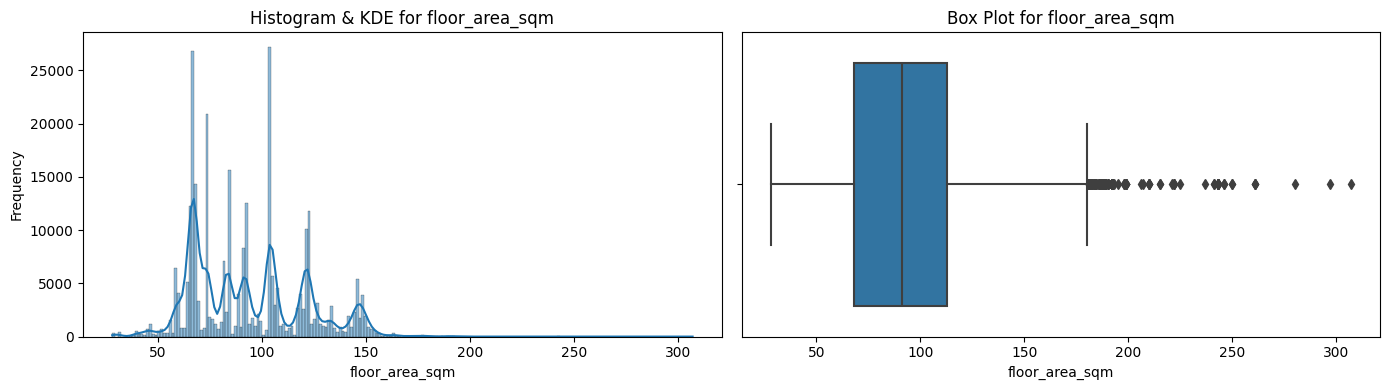

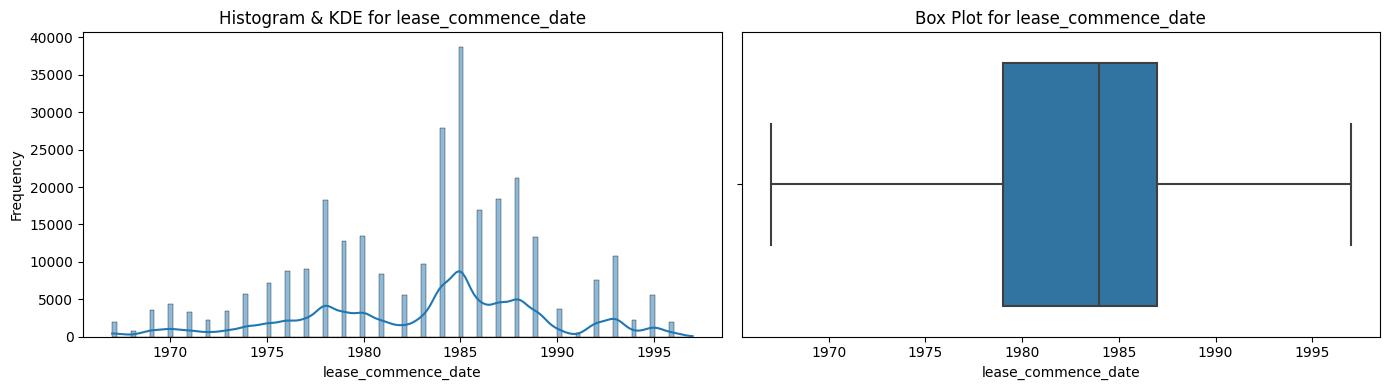

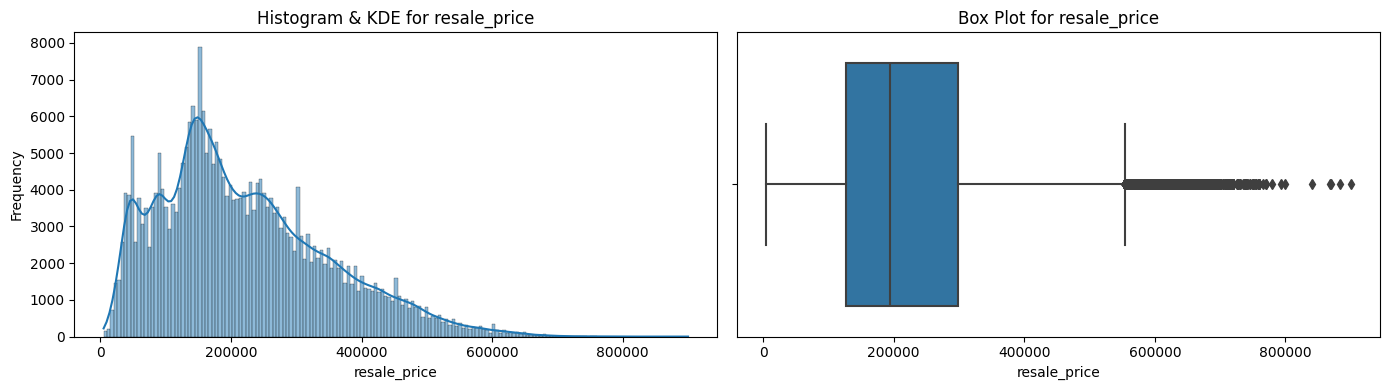

Skipping count plot for month (too many unique values: 120).
Skipping count plot for town (too many unique values: 26).


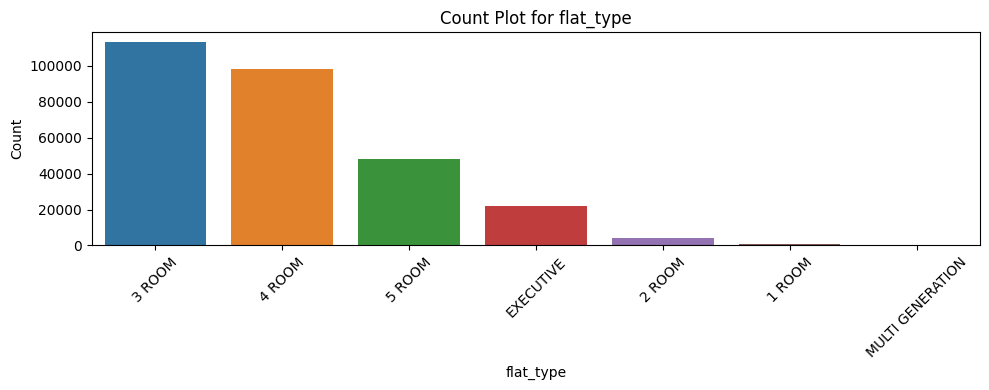

Skipping count plot for block (too many unique values: 1094).
Skipping count plot for street_name (too many unique values: 417).


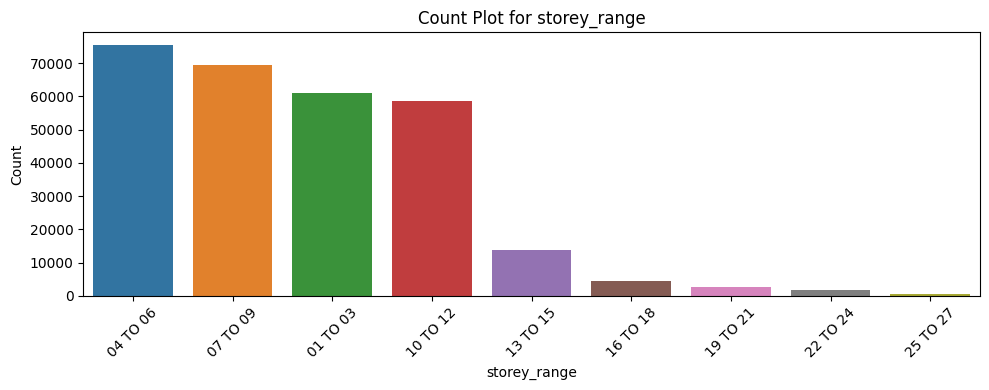

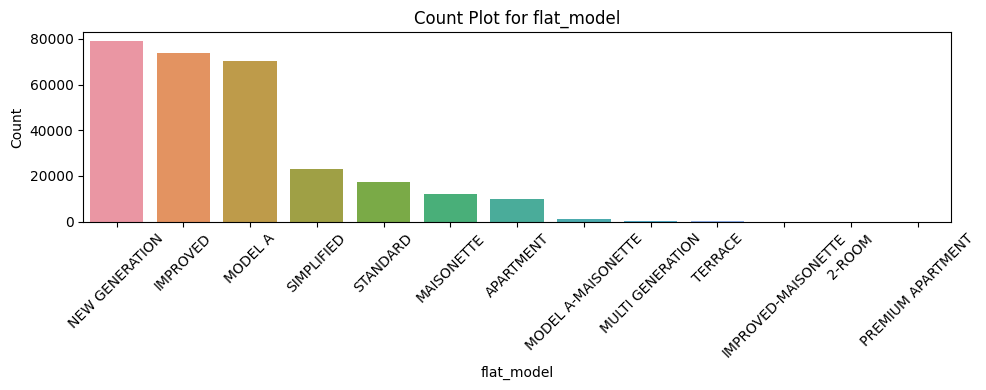

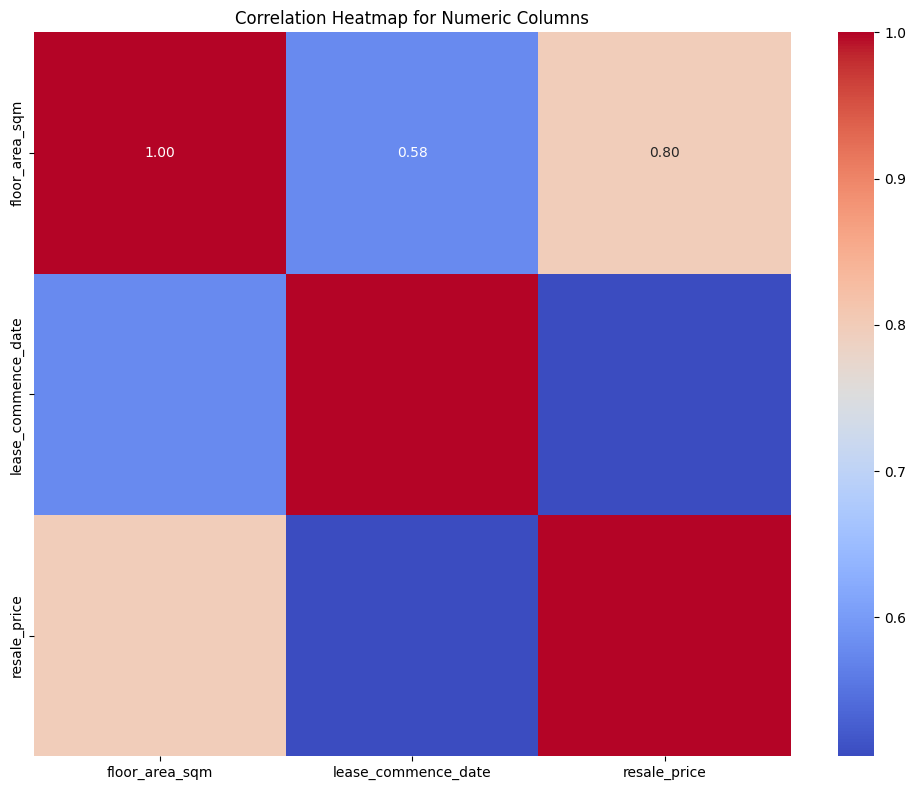


Reviewing file: ../data/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv

Basic Info:
Shape: (369651, 10)

Columns and Data Types:
1. month (dtype: object)
2. town (dtype: object)
3. flat_type (dtype: object)
4. block (dtype: object)
5. street_name (dtype: object)
6. storey_range (dtype: object)
7. floor_area_sqm (dtype: float64)
8. flat_model (dtype: object)
9. lease_commence_date (dtype: int64)
10. resale_price (dtype: float64)

First 5 Rows:
     month        town flat_type block       street_name storey_range  \
0  2000-01  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4     07 TO 09   
1  2000-01  ANG MO KIO    3 ROOM   174  ANG MO KIO AVE 4     04 TO 06   
2  2000-01  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     07 TO 09   
3  2000-01  ANG MO KIO    3 ROOM   215  ANG MO KIO AVE 1     07 TO 09   
4  2000-01  ANG MO KIO    3 ROOM   218  ANG MO KIO AVE 1     07 TO 09   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  
0            69.0       

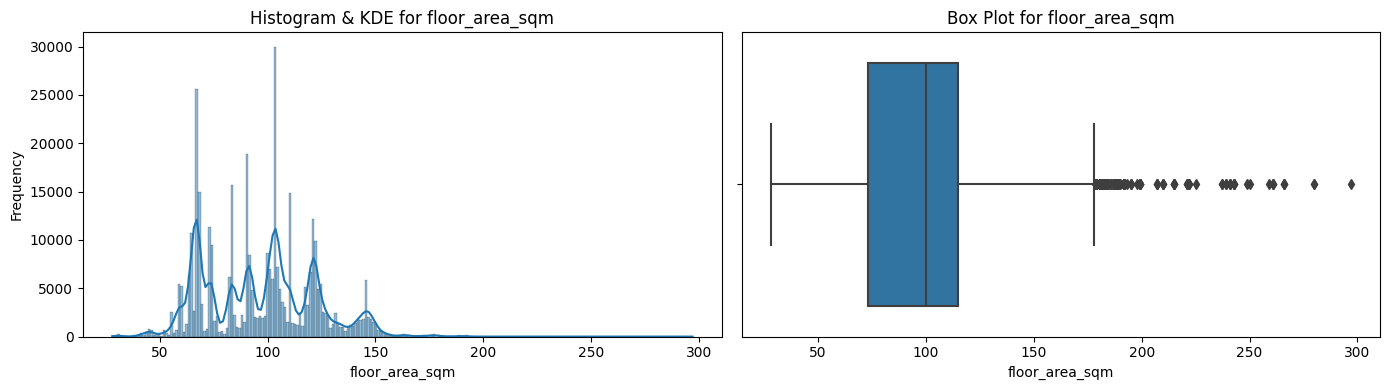

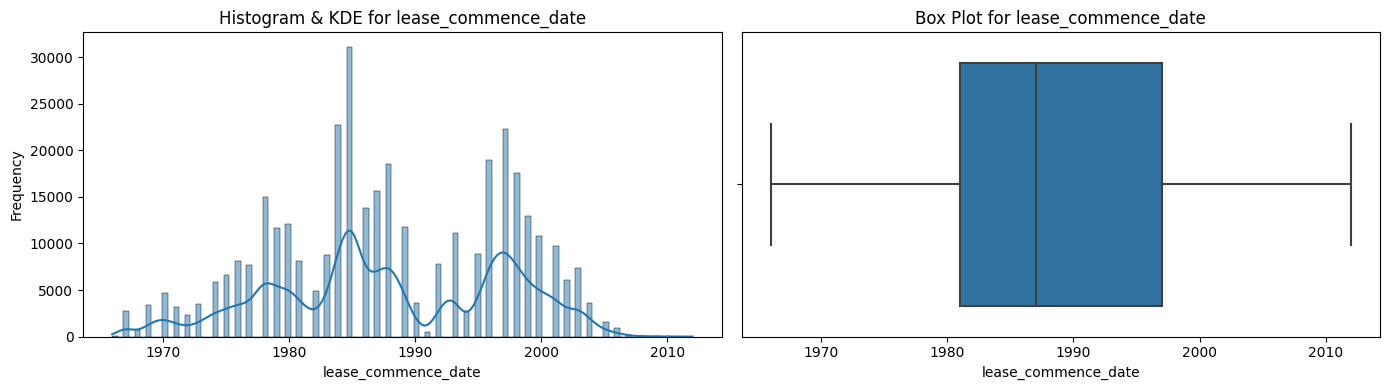

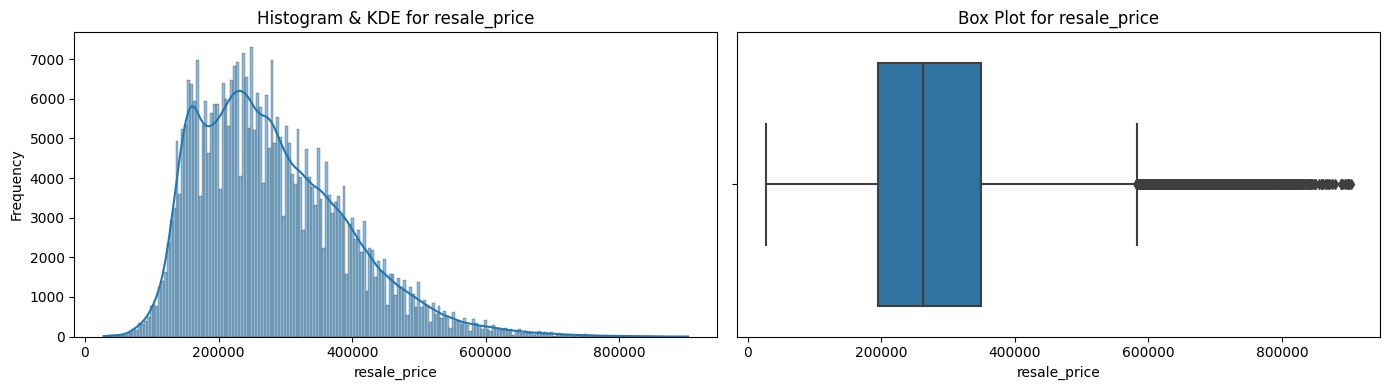

Skipping count plot for month (too many unique values: 146).
Skipping count plot for town (too many unique values: 26).


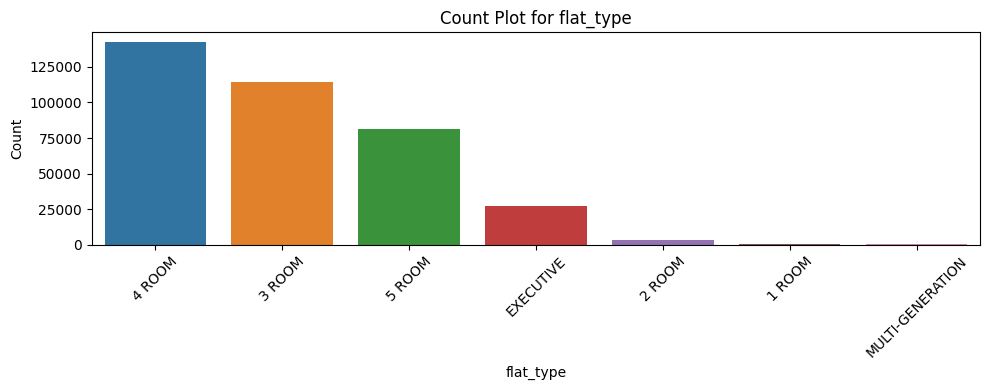

Skipping count plot for block (too many unique values: 1991).
Skipping count plot for street_name (too many unique values: 523).


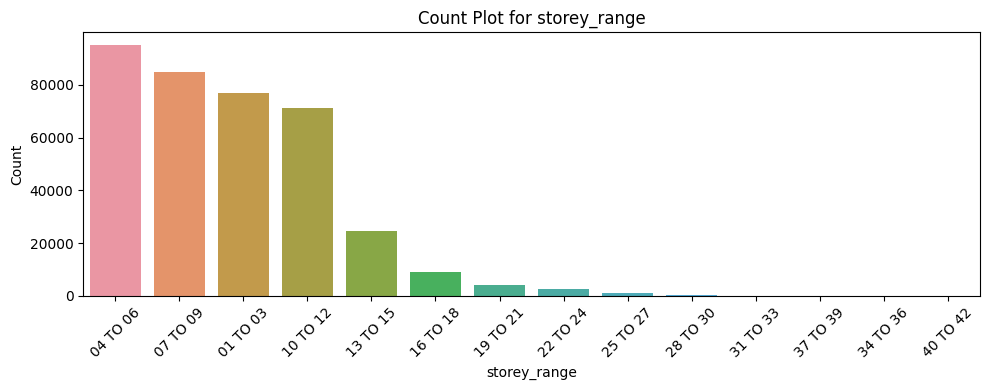

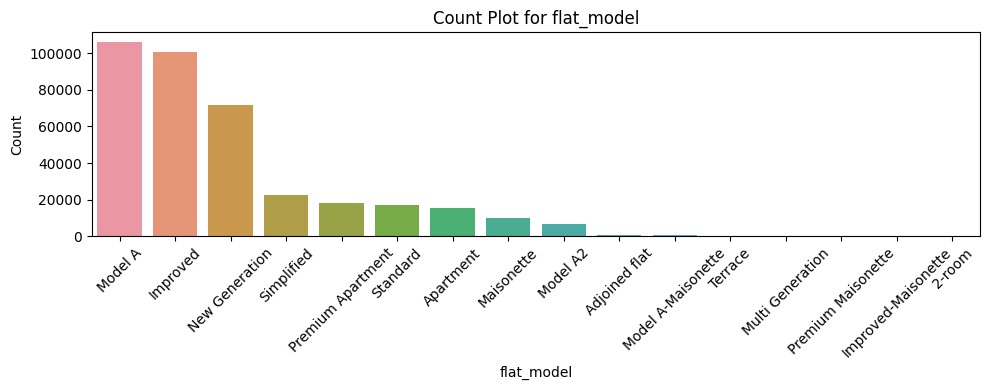

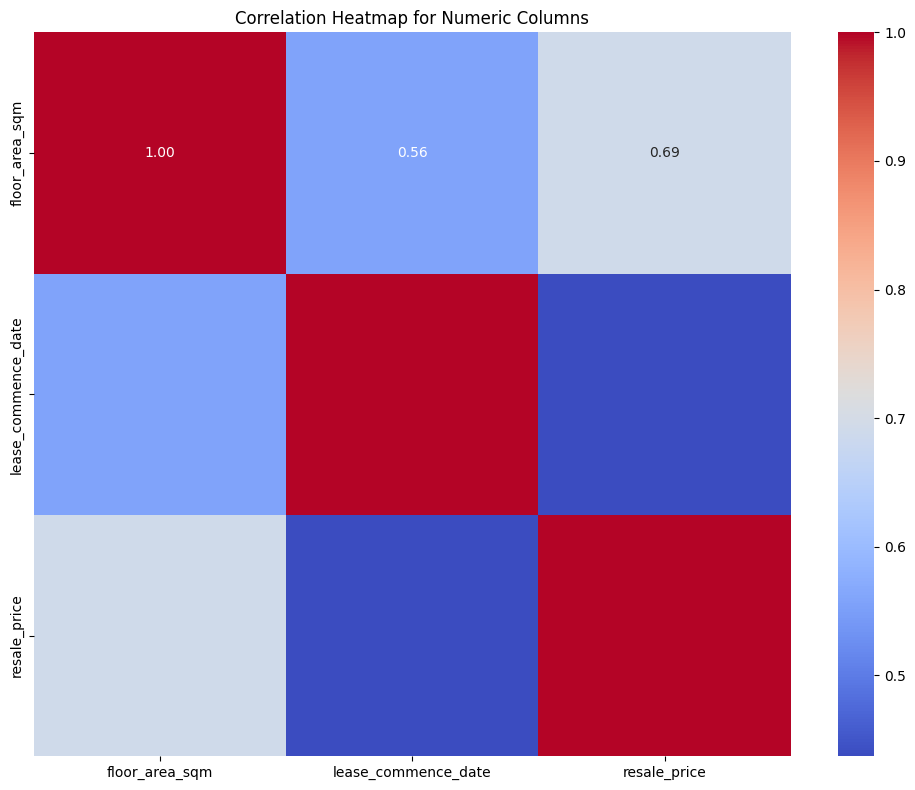


Reviewing file: ../data/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv

Basic Info:
Shape: (52203, 10)

Columns and Data Types:
1. month (dtype: object)
2. town (dtype: object)
3. flat_type (dtype: object)
4. block (dtype: object)
5. street_name (dtype: object)
6. storey_range (dtype: object)
7. floor_area_sqm (dtype: float64)
8. flat_model (dtype: object)
9. lease_commence_date (dtype: int64)
10. resale_price (dtype: float64)

First 5 Rows:
     month        town flat_type block        street_name storey_range  \
0  2012-03  ANG MO KIO    2 ROOM   172   ANG MO KIO AVE 4     06 TO 10   
1  2012-03  ANG MO KIO    2 ROOM   510   ANG MO KIO AVE 8     01 TO 05   
2  2012-03  ANG MO KIO    3 ROOM   610   ANG MO KIO AVE 4     06 TO 10   
3  2012-03  ANG MO KIO    3 ROOM   474  ANG MO KIO AVE 10     01 TO 05   
4  2012-03  ANG MO KIO    3 ROOM   604   ANG MO KIO AVE 5     06 TO 10   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  
0    

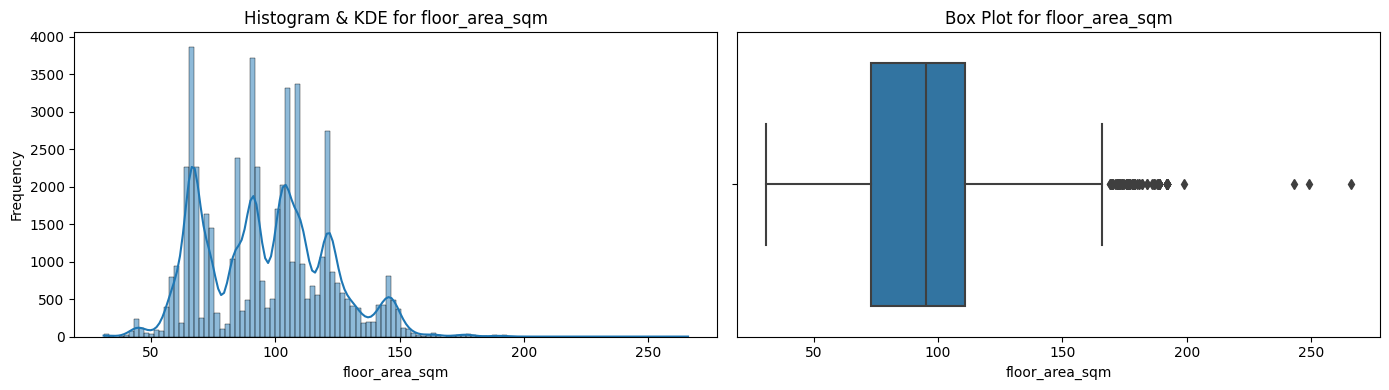

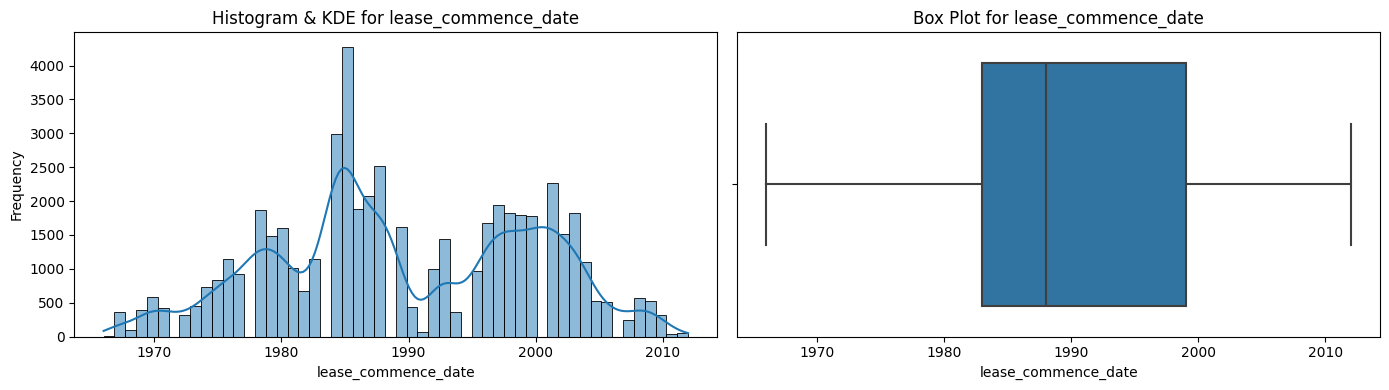

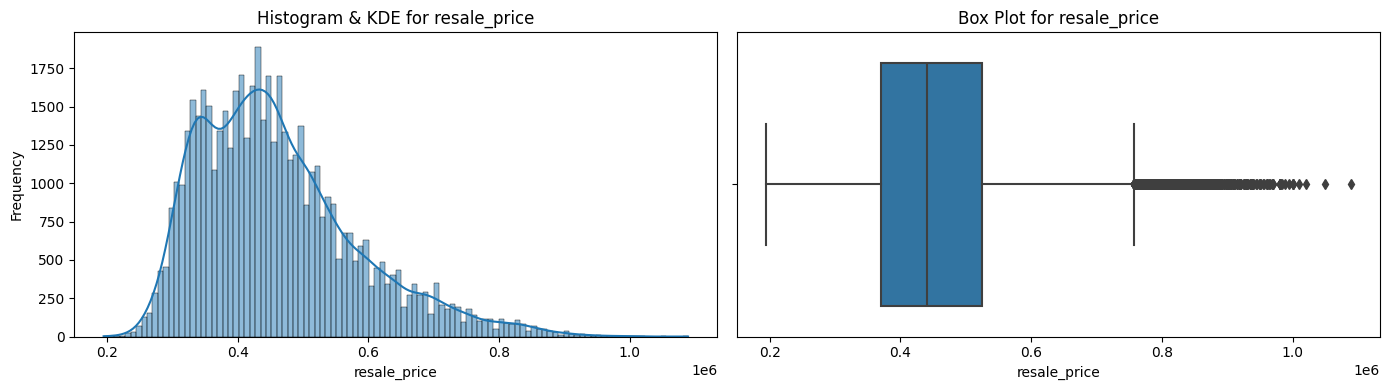

Skipping count plot for month (too many unique values: 34).
Skipping count plot for town (too many unique values: 26).


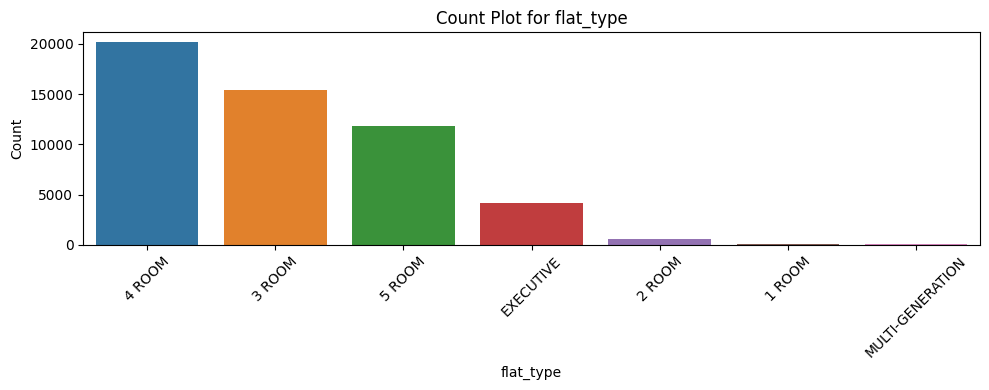

Skipping count plot for block (too many unique values: 2047).
Skipping count plot for street_name (too many unique values: 515).
Skipping count plot for storey_range (too many unique values: 22).


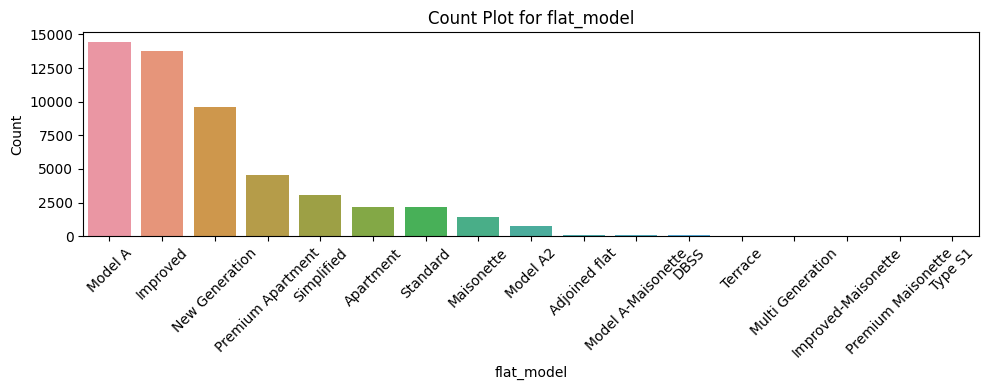

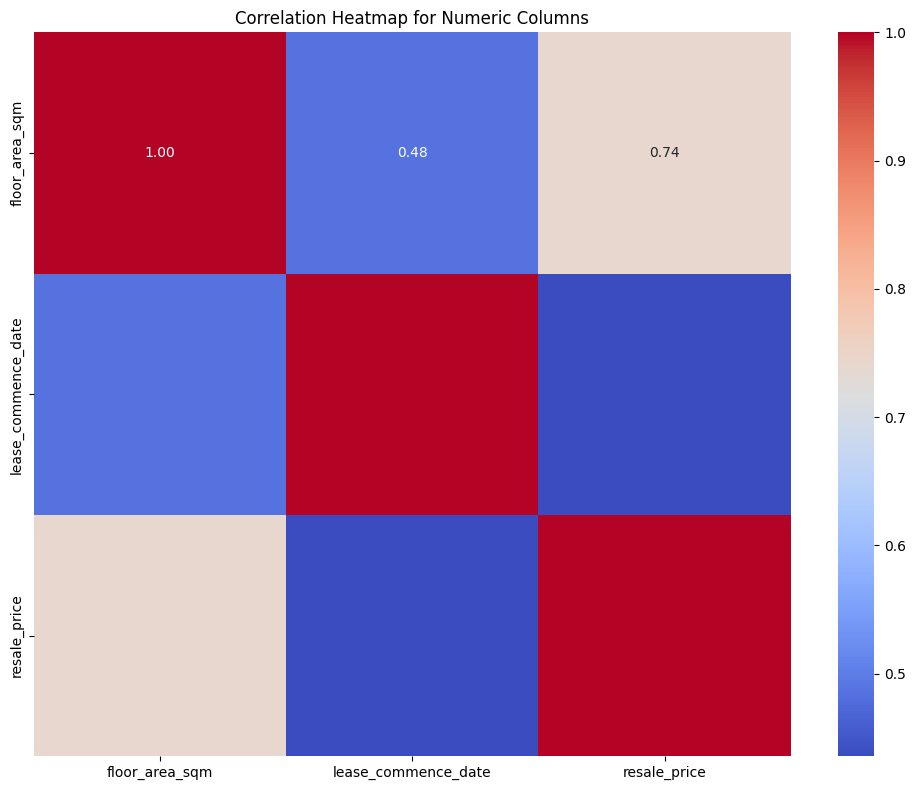


Reviewing file: ../data/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv

Basic Info:
Shape: (37153, 11)

Columns and Data Types:
1. month (dtype: object)
2. town (dtype: object)
3. flat_type (dtype: object)
4. block (dtype: object)
5. street_name (dtype: object)
6. storey_range (dtype: object)
7. floor_area_sqm (dtype: float64)
8. flat_model (dtype: object)
9. lease_commence_date (dtype: int64)
10. remaining_lease (dtype: int64)
11. resale_price (dtype: float64)

First 5 Rows:
     month        town flat_type block        street_name storey_range  \
0  2015-01  ANG MO KIO    3 ROOM   174   ANG MO KIO AVE 4     07 TO 09   
1  2015-01  ANG MO KIO    3 ROOM   541  ANG MO KIO AVE 10     01 TO 03   
2  2015-01  ANG MO KIO    3 ROOM   163   ANG MO KIO AVE 4     01 TO 03   
3  2015-01  ANG MO KIO    3 ROOM   446  ANG MO KIO AVE 10     01 TO 03   
4  2015-01  ANG MO KIO    3 ROOM   557  ANG MO KIO AVE 10     07 TO 09   

   floor_area_sqm      flat_model  lease_

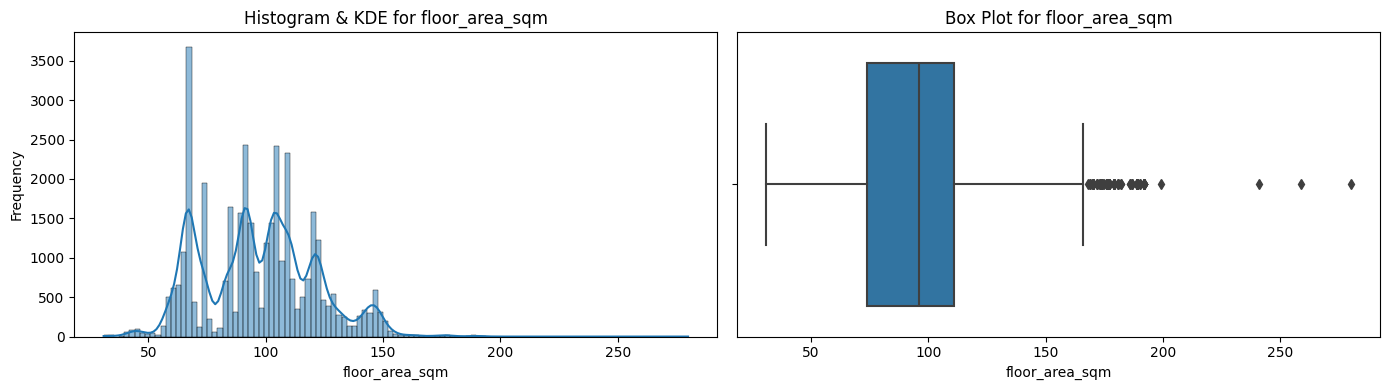

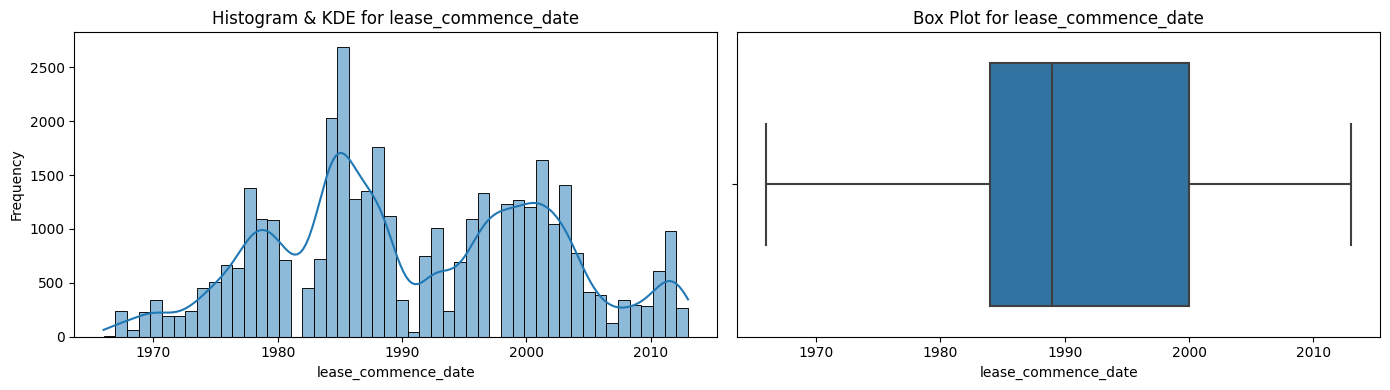

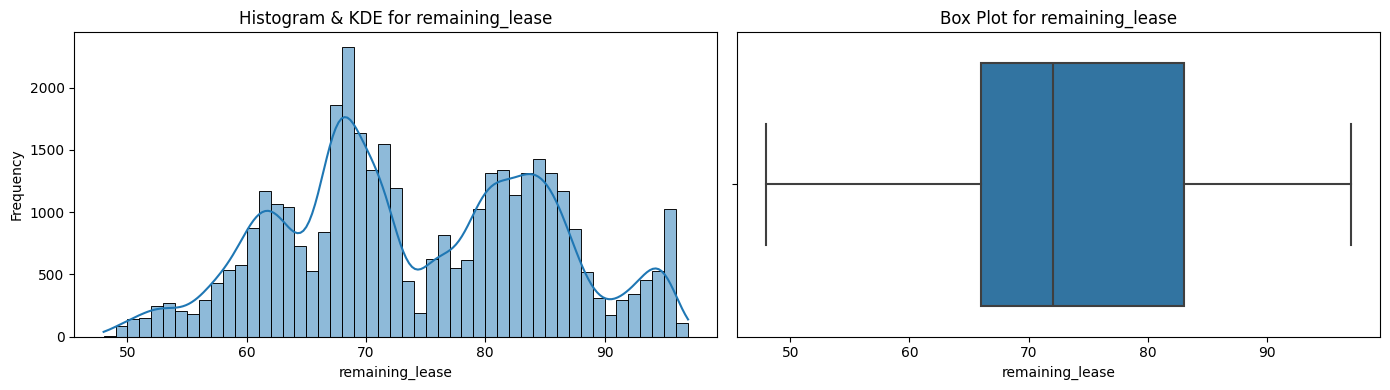

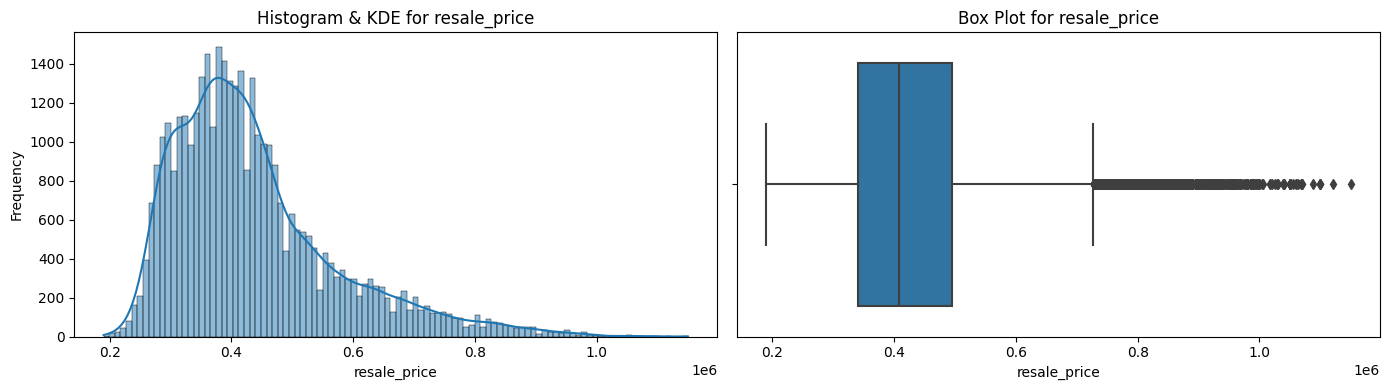

Skipping count plot for month (too many unique values: 24).
Skipping count plot for town (too many unique values: 26).


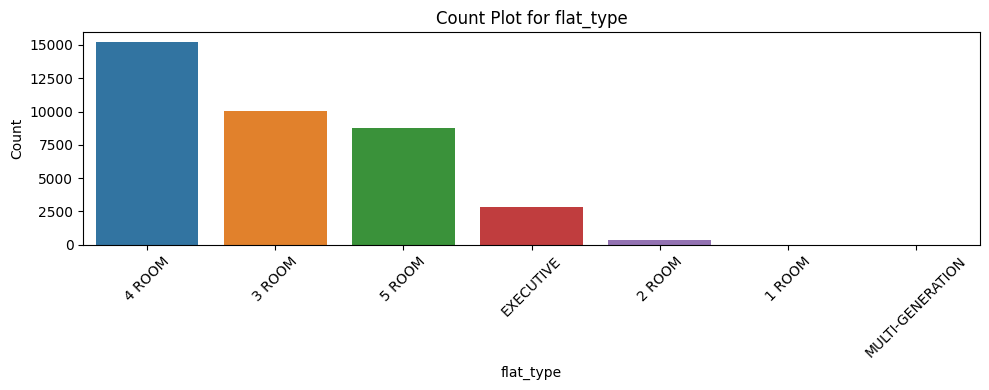

Skipping count plot for block (too many unique values: 2108).
Skipping count plot for street_name (too many unique values: 519).


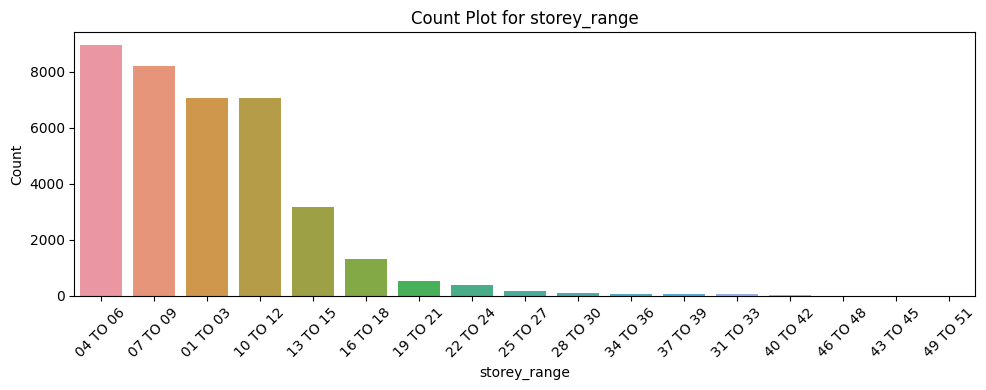

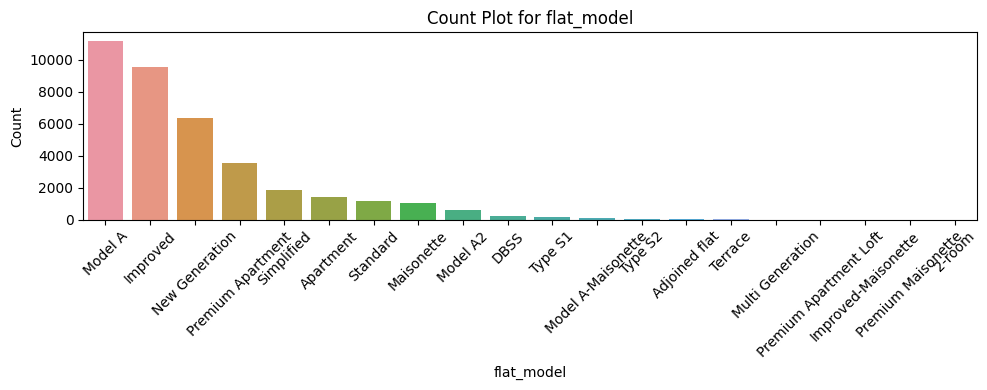

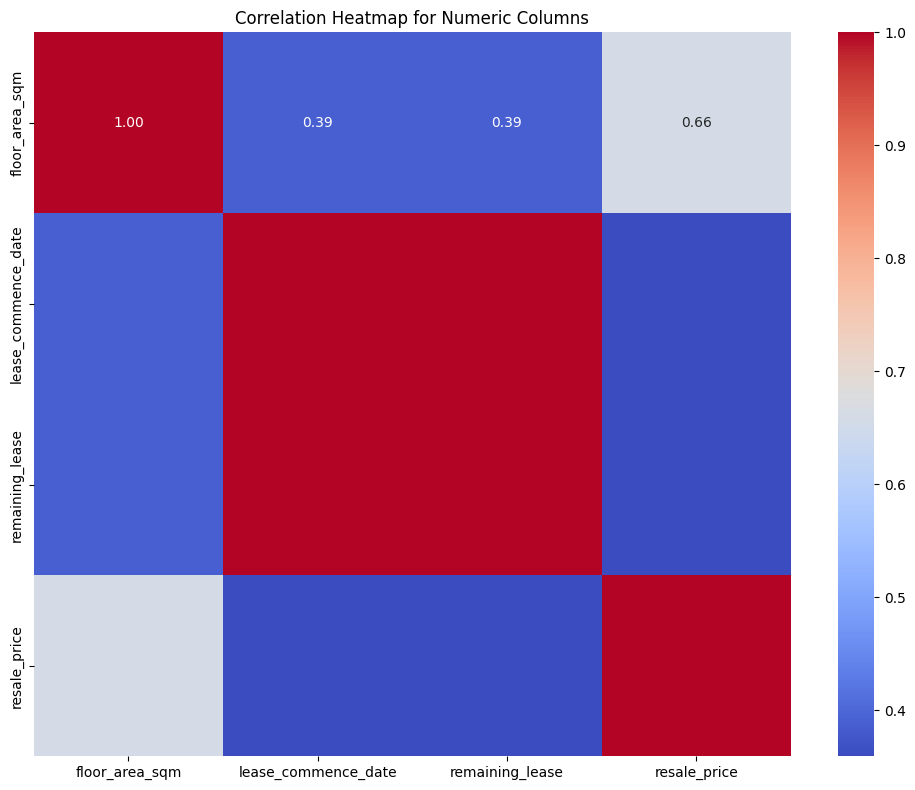


Reviewing file: ../data/Resale flat prices based on registration date from Jan-2017 onwards.csv

Basic Info:
Shape: (202759, 11)

Columns and Data Types:
1. month (dtype: object)
2. town (dtype: object)
3. flat_type (dtype: object)
4. block (dtype: object)
5. street_name (dtype: object)
6. storey_range (dtype: object)
7. floor_area_sqm (dtype: float64)
8. flat_model (dtype: object)
9. lease_commence_date (dtype: int64)
10. remaining_lease (dtype: object)
11. resale_price (dtype: float64)

First 5 Rows:
     month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_comme

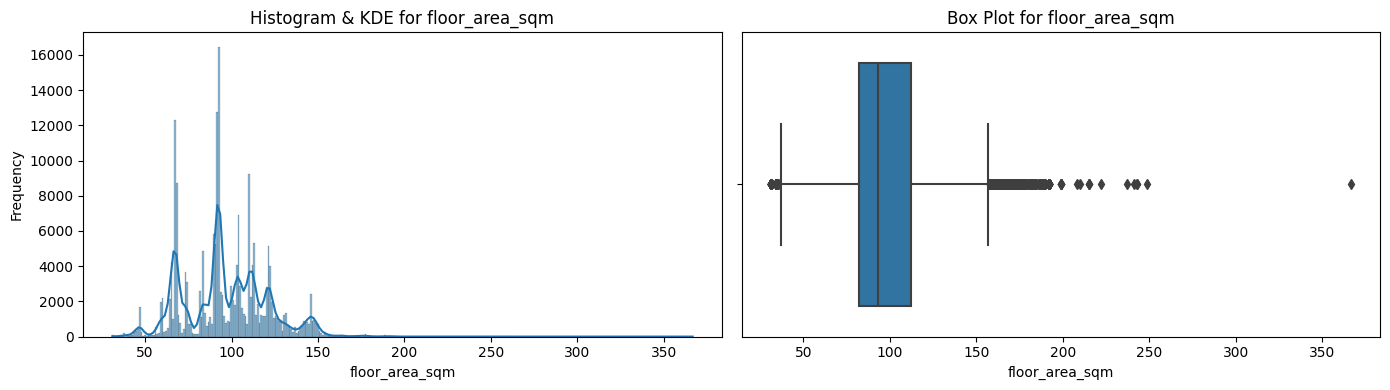

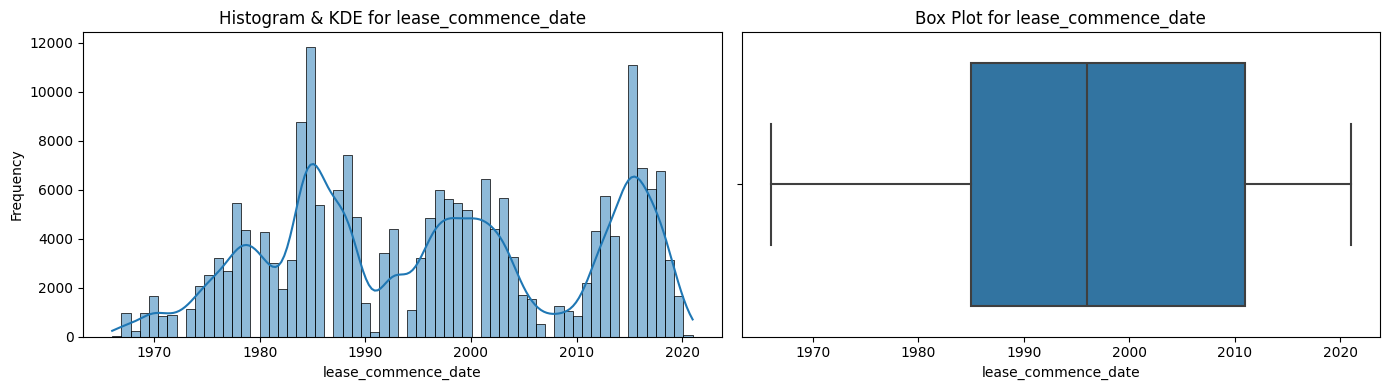

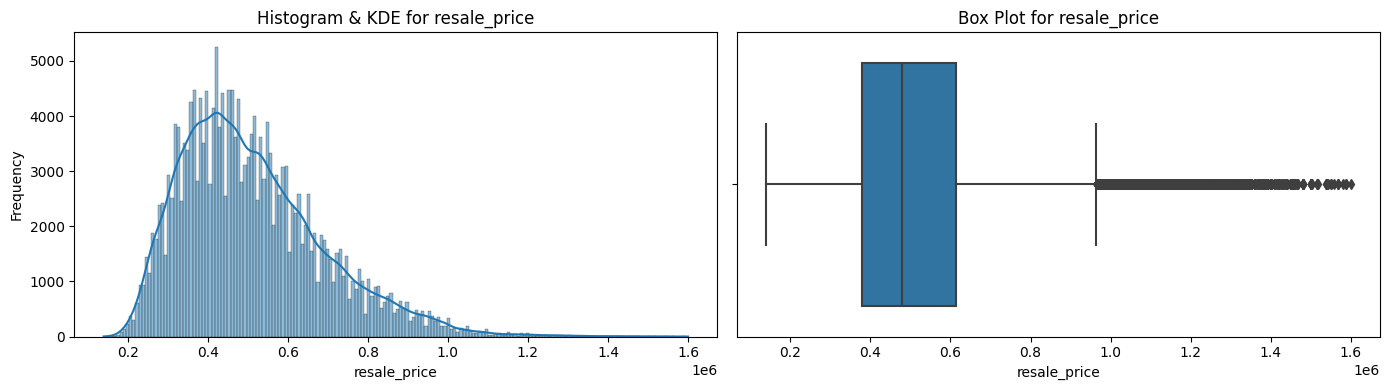

Skipping count plot for month (too many unique values: 99).
Skipping count plot for town (too many unique values: 26).


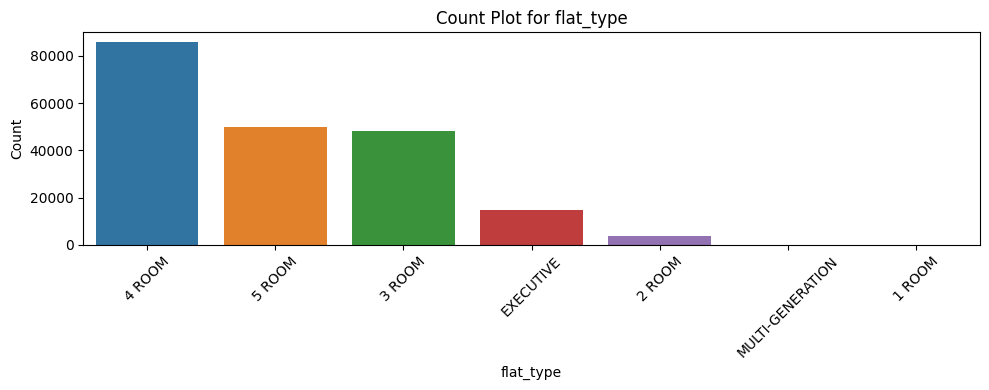

Skipping count plot for block (too many unique values: 2734).
Skipping count plot for street_name (too many unique values: 572).


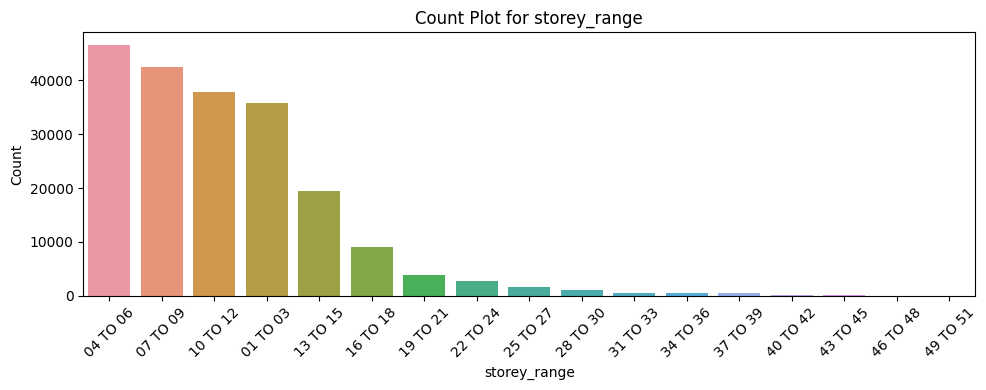

Skipping count plot for flat_model (too many unique values: 21).
Skipping count plot for remaining_lease (too many unique values: 685).


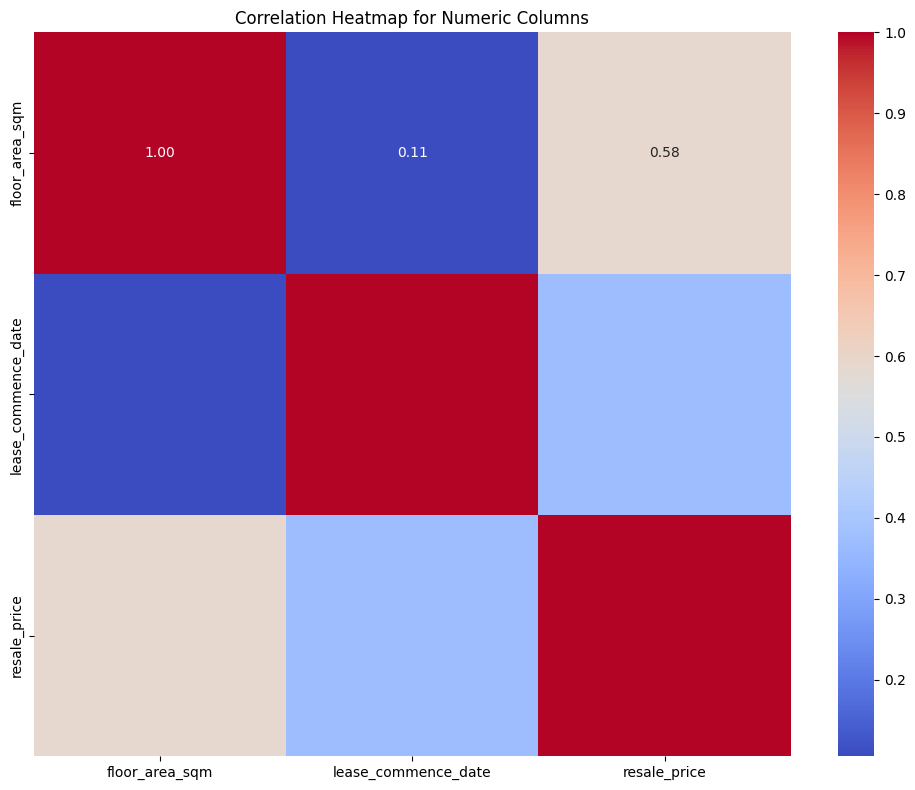

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def detailed_explore_file(file, save_plots=False, output_dir=None):
    """
    Reads a CSV file, prints detailed summary statistics, and generates multiple plots:
      - Basic info: shape, columns, data types, first rows.
      - Missing value analysis: counts and percentages.
      - Unique counts per column.
      - Descriptive statistics for numeric columns (including skewness and kurtosis).
      - Distribution plots for numeric columns (histogram with KDE and box plot).
      - Count plots for categorical columns (if few unique values).
      - Correlation heatmap for numeric columns.
    
    Parameters:
      file (str): Path to the CSV file.
      save_plots (bool): Whether to save plots as image files.
      output_dir (str): Directory to save plots if save_plots is True.
    
    Returns:
      df (DataFrame): The loaded DataFrame.
    """
    print("=" * 80)
    print(f"Reviewing file: {file}")
    
    try:
        df = pd.read_csv(file)
    except Exception as e:
        print(f"Error reading file {file}: {e}")
        return None
    
    print("\nBasic Info:")
    print("Shape:", df.shape)
    print("\nColumns and Data Types:")
    for i, col in enumerate(df.columns, start=1):
        print(f"{i}. {col} (dtype: {df[col].dtype})")
    
    print("\nFirst 5 Rows:")
    print(df.head())
    
    # Missing value analysis
    print("\nMissing Value Analysis:")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
    print(missing_df)
    
    print("\nDistinct Value Counts per Column:")
    for col in df.columns:
        unique_count = df[col].nunique()
        print(f"{col}: {unique_count} unique values")
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print("\nDescriptive Statistics for Numeric Columns:")
        desc = df[numeric_cols].describe().T
        desc['skew'] = df[numeric_cols].skew()
        desc['kurtosis'] = df[numeric_cols].kurtosis()
        print(desc)
    else:
        print("\nNo numeric columns found.")
        
    if len(numeric_cols) > 0:
        for col in numeric_cols:
            fig, axes = plt.subplots(1, 2, figsize=(14, 4))
            
            sns.histplot(df[col].dropna(), kde=True, ax=axes[0])
            axes[0].set_title(f"Histogram & KDE for {col}")
            axes[0].set_xlabel(col)
            axes[0].set_ylabel("Frequency")
            
            # Box plot
            sns.boxplot(x=df[col].dropna(), ax=axes[1])
            axes[1].set_title(f"Box Plot for {col}")
            axes[1].set_xlabel(col)
            
            plt.tight_layout()
            if save_plots and output_dir:
                plt.savefig(f"{output_dir}/{col}_distribution.png")
                plt.close()
            else:
                plt.show()
    else:
        print("No numeric columns to plot distributions.")
    
    # Plot count plots for categorical columns (if they have <=20 unique values)
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        unique_count = df[col].nunique()
        if unique_count <= 20:
            plt.figure(figsize=(10, 4))
            order = df[col].value_counts().index
            sns.countplot(data=df, x=col, order=order)
            plt.title(f"Count Plot for {col}")
            plt.xticks(rotation=45)
            plt.ylabel("Count")
            plt.tight_layout()
            if save_plots and output_dir:
                plt.savefig(f"{output_dir}/{col}_countplot.png")
                plt.close()
            else:
                plt.show()
        else:
            print(f"Skipping count plot for {col} (too many unique values: {unique_count}).")
    
    # Correlation heatmap for numeric columns (if there are at least 2)
    if len(numeric_cols) >= 2:
        plt.figure(figsize=(10, 8))
        corr = df[numeric_cols].corr()
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Correlation Heatmap for Numeric Columns")
        plt.tight_layout()
        if save_plots and output_dir:
            plt.savefig(f"{output_dir}/numeric_correlation_heatmap.png")
            plt.close()
        else:
            plt.show()
    else:
        print("Not enough numeric columns for a correlation heatmap.")
    
    print("=" * 80, "\n")
    return df

file_names = [
    '../data/Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv', 
    '../data/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv', 
    '../data/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv', 
    '../data/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv', 
    '../data/Resale flat prices based on registration date from Jan-2017 onwards.csv'
]

for file in file_names:
    detailed_explore_file(file)



Total initial rows across all files: 948962
Total rows after cleaning: 948962
Total data points lost during cleaning: 0


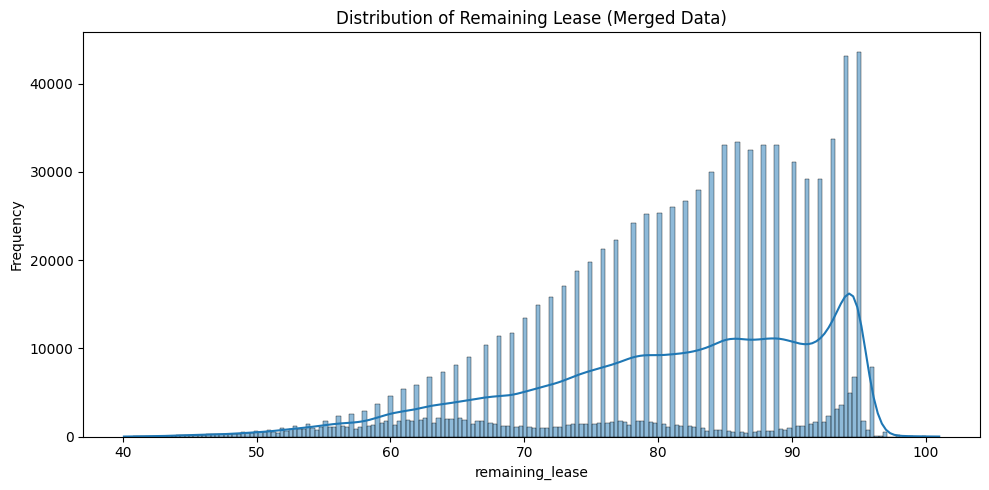


Descriptive Statistics of Merged Data:
       floor_area_sqm  lease_commence_date  resale_price  remaining_lease
count   948962.000000        948962.000000  9.489620e+05    948962.000000
mean        95.676691          1988.502663  3.278592e+05        80.907586
std         25.784833            10.890188  1.771736e+05        10.926094
min         28.000000          1966.000000  5.000000e+03        40.083333
25%         73.000000          1981.000000  1.950000e+05        74.000000
50%         93.000000          1986.000000  3.010000e+05        83.000000
75%        113.000000          1996.000000  4.250000e+05        90.000000
max        366.700000          2021.000000  1.600000e+06       101.000000
Reviewing file: merged_data.csv

Basic Info:
Shape: (948962, 11)

Columns and Data Types:
1. month (dtype: object)
2. town (dtype: object)
3. flat_type (dtype: object)
4. block (dtype: object)
5. street_name (dtype: object)
6. storey_range (dtype: object)
7. floor_area_sqm (dtype: float64)
8. 

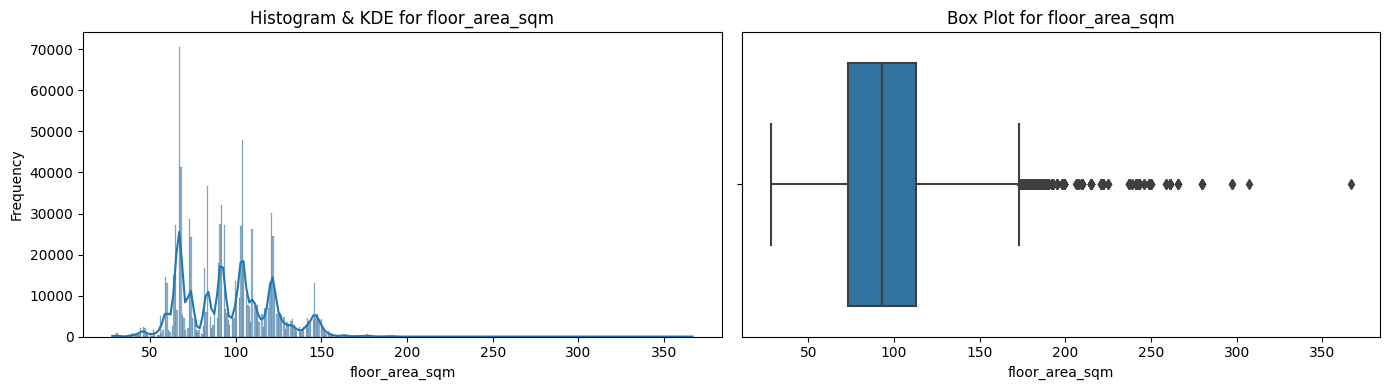

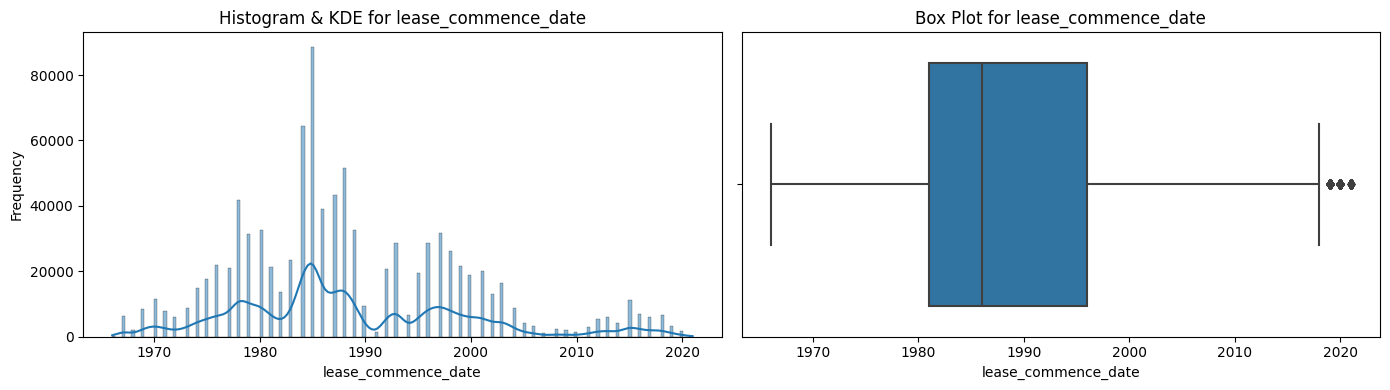

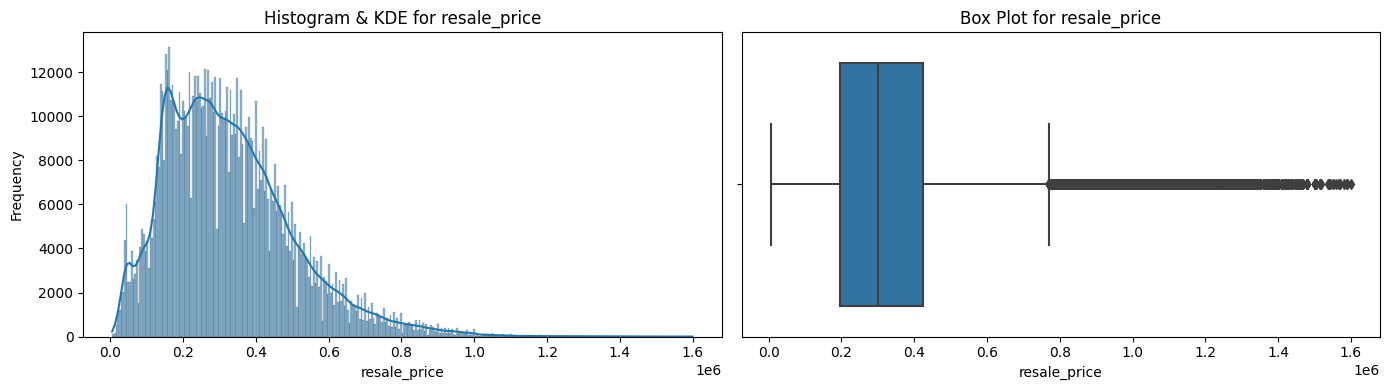

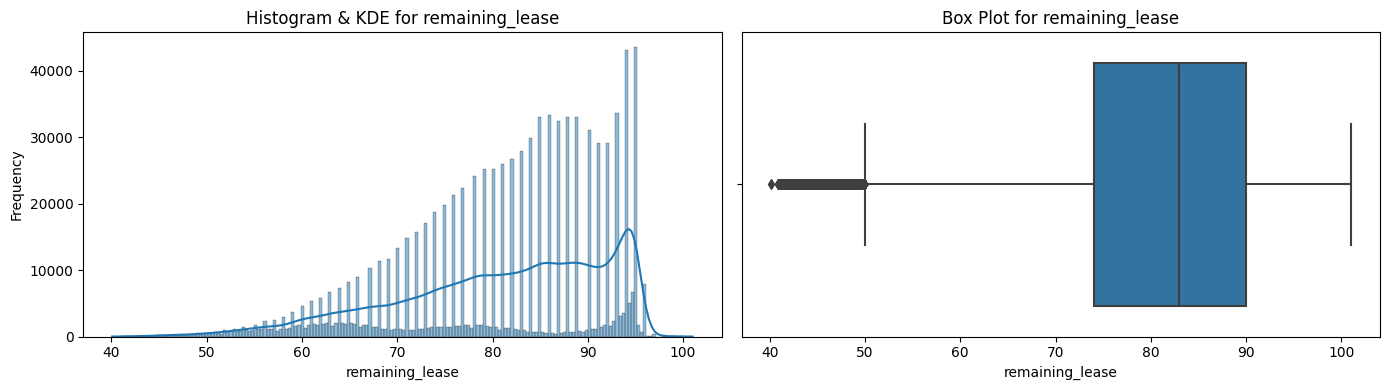

Skipping count plot for month (too many unique values: 423).
Skipping count plot for town (too many unique values: 27).


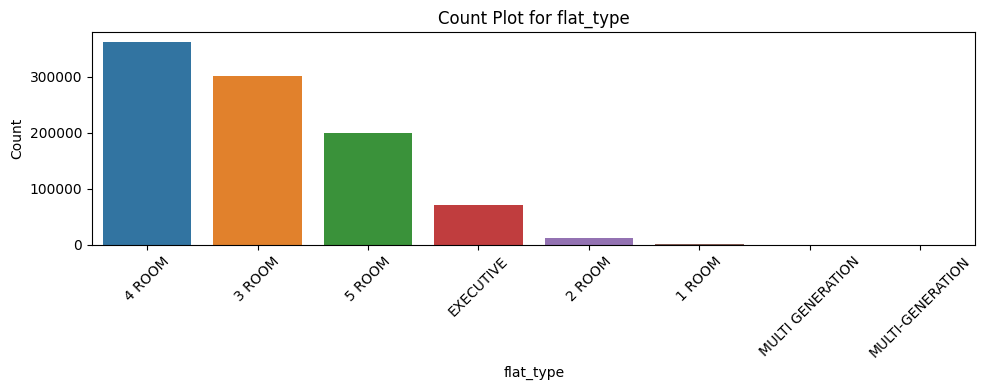

Skipping count plot for block (too many unique values: 2737).
Skipping count plot for street_name (too many unique values: 590).
Skipping count plot for storey_range (too many unique values: 25).
Skipping count plot for flat_model (too many unique values: 34).


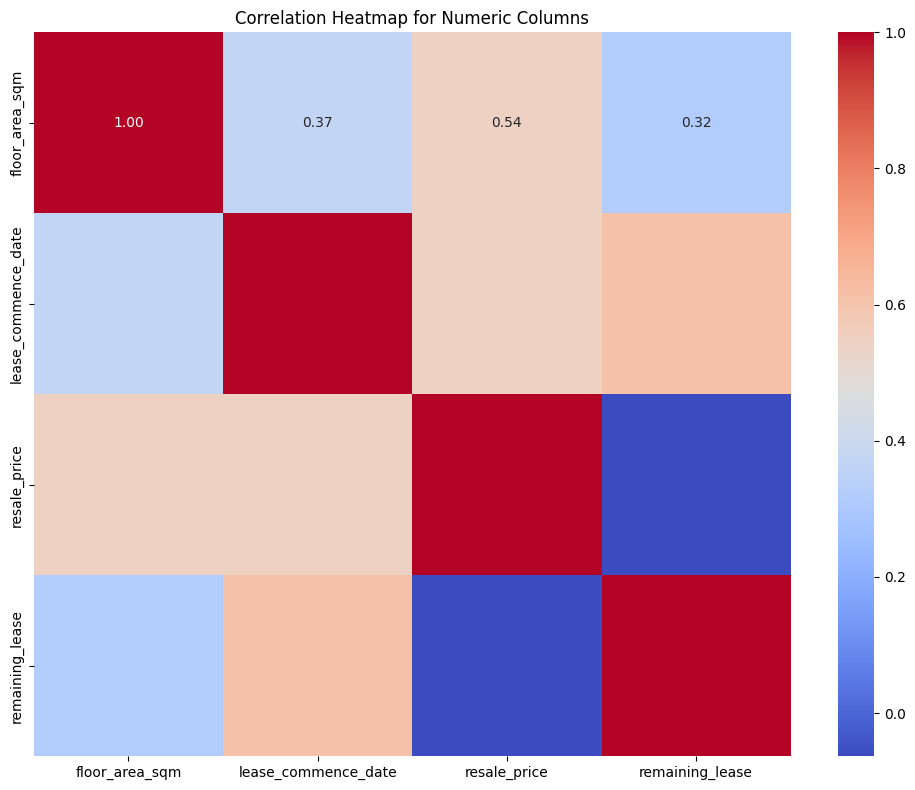

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,86.000000
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,86.000000
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,86.000000
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,86.000000
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,85.000000
...,...,...,...,...,...,...,...,...,...,...,...
948957,2025-02,YISHUN,EXECUTIVE,643,YISHUN ST 61,01 TO 03,142.0,Apartment,1987,830000.0,61.666667
948958,2025-02,YISHUN,EXECUTIVE,723,YISHUN ST 71,07 TO 09,146.0,Maisonette,1986,818888.0,60.416667
948959,2025-01,YISHUN,EXECUTIVE,836,YISHUN ST 81,01 TO 03,146.0,Maisonette,1988,960000.0,62.166667
948960,2025-02,YISHUN,EXECUTIVE,824,YISHUN ST 81,01 TO 03,145.0,Apartment,1987,868888.0,61.833333


In [7]:
def parse_remaining_lease(lease_val):
    """
    Converts a lease value from a string like "86 years 1 months" to a numeric value (in years).
    Returns: years + (months/12) if possible, otherwise returns NaN.
    """
    try:
        if isinstance(lease_val, str):
            lease_val = lease_val.replace(',', '').strip()
            parts = lease_val.split()
            years = float(parts[0])
            if len(parts) >= 3:
                months = float(parts[2])
                return years + months / 12.0
            else:
                return years
        else:
            return float(lease_val)
    except Exception as e:
        return np.nan

def load_and_clean_file(file):
    """
    Loads a CSV file and performs initial cleaning:
      - Drops rows with missing values.
      - Computes or converts the 'remaining_lease' column.
    Returns the cleaned dataframe along with the row counts before and after cleaning.
    """
    try:
        df = pd.read_csv(file)
        initial_count = len(df)
        
        # Drop rows with missing values (this may be refined later)
        df = df.dropna()
        cleaned_count = len(df)
        
        # Compute or convert remaining_lease
        if 'remaining_lease' not in df.columns:
            # For older files, assume 'month' exists and 'lease_commence_date' is numeric.
            df['year'] = df['month'].str[:4].astype(int)
            df['remaining_lease'] = (df['lease_commence_date'] + 99) - df['year']
            df.drop(columns=['year'], inplace=True)
        else:
            df['remaining_lease'] = df['remaining_lease'].apply(parse_remaining_lease)
        
        return df, initial_count, cleaned_count
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        return None, 0, 0

def merge_datasets(file_names):
    """
    Iterates over a list of CSV files, cleans them, and merges them into a single DataFrame.
    Also returns lists of initial and cleaned row counts for reporting data loss.
    """
    initial_counts = []
    final_counts = []
    dfs = []
    for file in file_names:
        df, init_count, clean_count = load_and_clean_file(file)
        if df is not None:
            dfs.append(df)
            initial_counts.append(init_count)
            final_counts.append(clean_count)
    merged_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    return merged_df, initial_counts, final_counts

def plot_distribution(df, column, title=None, save_plot=False, output_path=None):
    """
    Plots the histogram (with KDE) of a given column from the DataFrame.
    Optionally saves the plot to a file.
    """
    plt.figure(figsize=(10, 5))
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(title if title else f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    if save_plot and output_path:
        plt.savefig(output_path)
        plt.close()
    else:
        plt.show()

def report_merge_stats(initial_counts, final_counts):
    """
    Prints a summary of the total rows before cleaning, after cleaning, and the lost rows.
    """
    total_initial = sum(initial_counts)
    total_final = sum(final_counts)
    lost_rows = total_initial - total_final
    print("Total initial rows across all files:", total_initial)
    print("Total rows after cleaning:", total_final)
    print("Total data points lost during cleaning:", lost_rows)
    return total_initial, total_final, lost_rows

file_names = [
    '../data/Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv', 
    '../data/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv', 
    '../data/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv', 
    '../data/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv', 
    '../data/Resale flat prices based on registration date from Jan-2017 onwards.csv'
]

merged_df, initial_counts, final_counts = merge_datasets(file_names)

total_initial, total_final, lost_rows = report_merge_stats(initial_counts, final_counts)

merged_df.to_csv("merged_data.csv", index=False)

# Plot key distributions after merging
plot_distribution(merged_df, "remaining_lease", title="Distribution of Remaining Lease (Merged Data)")
# (Guys you can add more plots for other important columns, e.g., resale_price, floor_area_sqm, etc.)

print("\nDescriptive Statistics of Merged Data:")
print(merged_df.describe())

detailed_explore_file("merged_data.csv")


     month        town          block  street_name  floor_area_sqm  \
0  1990-01  ANG MO KIO  236708.523598   256110.925           -1.55   
1  1990-01  ANG MO KIO  236708.523598   256110.925           -1.55   
2  1990-01  ANG MO KIO  236708.523598   256110.925           -1.55   
3  1990-01  ANG MO KIO  236708.523598   256110.925           -1.55   
4  1990-01  ANG MO KIO  305892.089196   256110.925           -0.50   

       flat_model  lease_commence_date  resale_price  remaining_lease  \
0        IMPROVED                 1977        9000.0           0.1875   
1        IMPROVED                 1977        6000.0           0.1875   
2        IMPROVED                 1977        8000.0           0.1875   
3        IMPROVED                 1977        6000.0           0.1875   
4  NEW GENERATION                 1976       47200.0           0.1250   

  transaction_date  ...  price_per_sqm  remaining_lease_ratio      region  \
0       1990-01-01  ...      -1.358163                 0.1875  

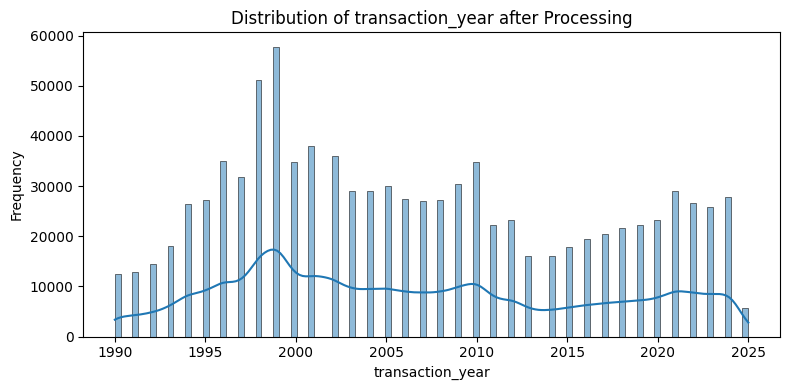

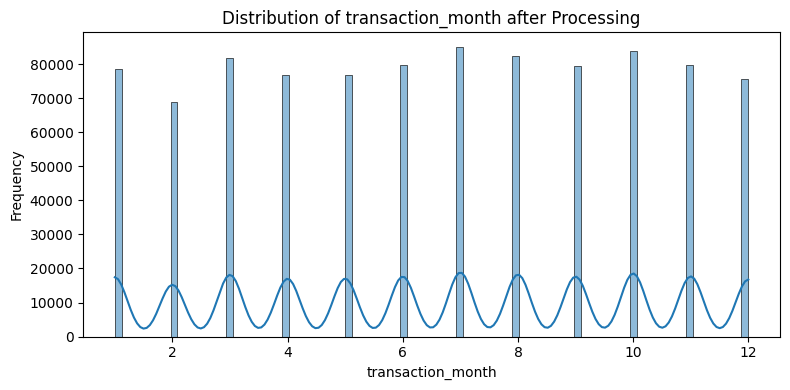

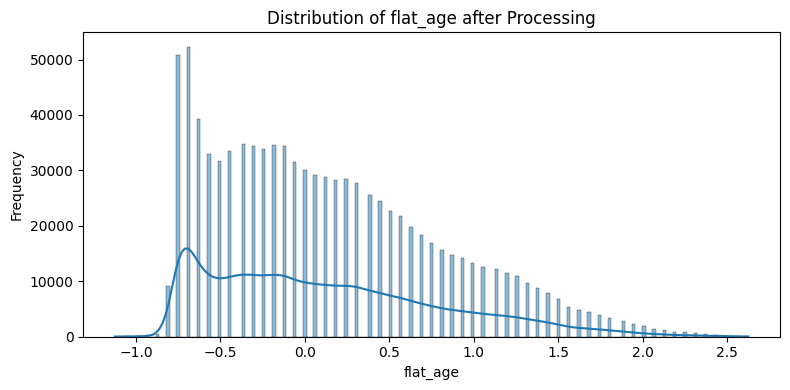

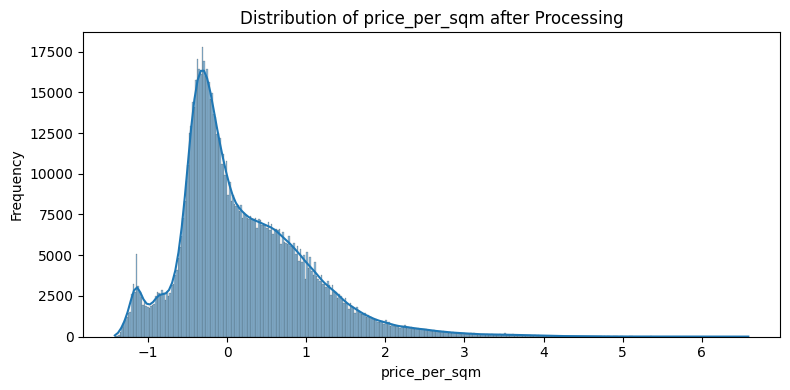

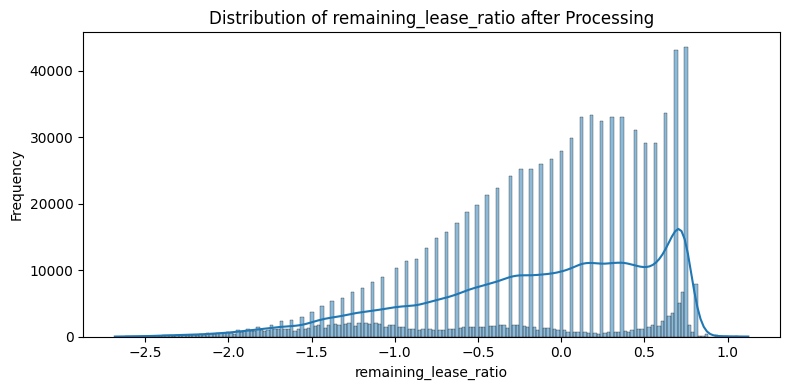

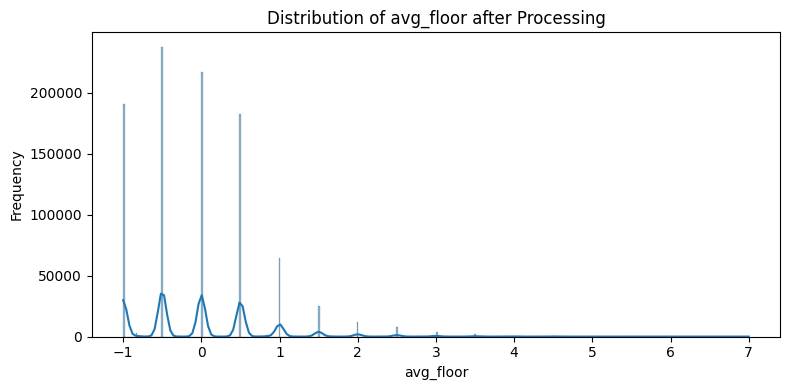

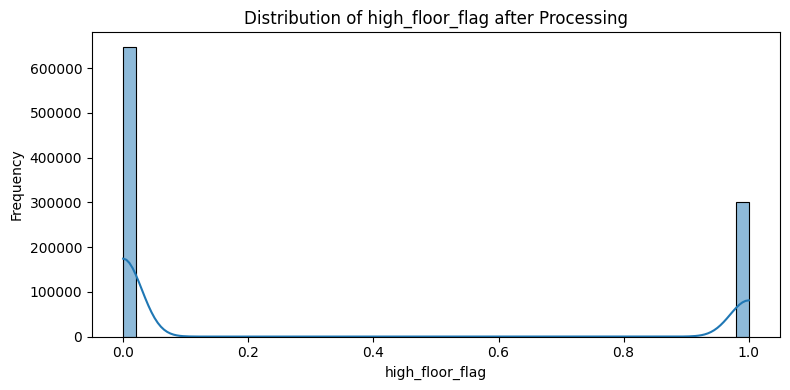

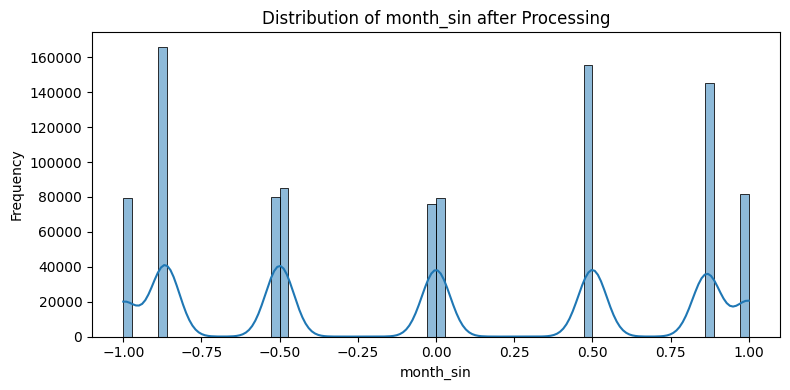

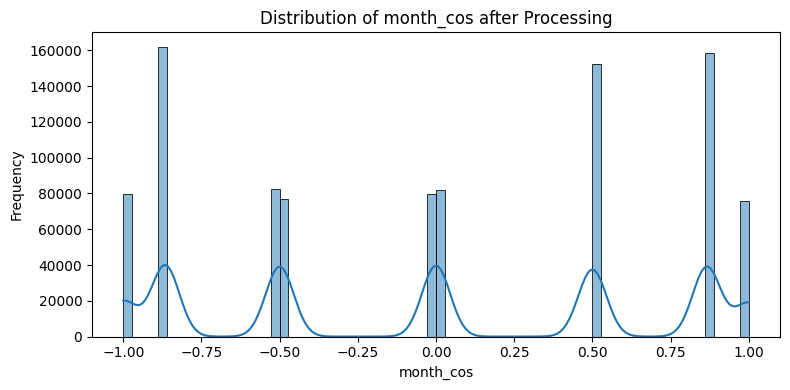

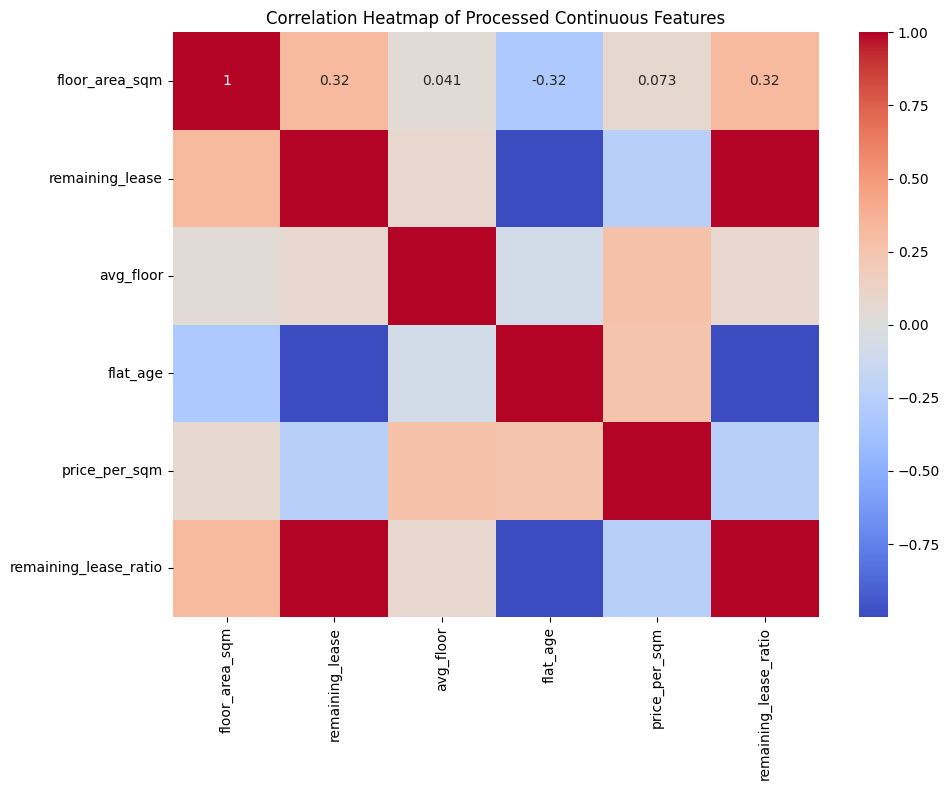

In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from category_encoders import TargetEncoder

# Dynamic Location Mapping
def map_towns_to_regions(df, town_col='town'):
    """
    Generates a mapping from towns to regions dynamically.
    Uses a default mapping for known towns, and assigns 'Other' for unknown ones.
    """
    # Default mapping based on domain knowledge can be changed later
    default_mapping = {
        'ANG MO KIO': 'North-East',
        'BEDOK': 'East',
        'BISHAN': 'Central',
        'BUKIT BATOK': 'West',
        'BUKIT MERAH': 'Central',
        'BUKIT PANJANG': 'West',
        'BUKIT TIMAH': 'Central',
        'CENTRAL AREA': 'Central',
        'CHOA CHU KANG': 'West',
        'CLEMENTI': 'West',
        'GEYLANG': 'Central',
        'HOUGANG': 'North-East',
        'JURONG EAST': 'West',
        'JURONG WEST': 'West',
        'KALLANG/WHAMPOA': 'Central',
        'MARINE PARADE': 'East',
        'PASIR RIS': 'East',
        'PUNGGOL': 'North-East',
        'QUEENSTOWN': 'Central',
        'SEMBAWANG': 'North',
        'SENGKANG': 'North-East',
        'SERANGOON': 'North-East',
        'TAMPINES': 'East',
        'TOA PAYOH': 'Central',
        'WOODLANDS': 'North',
        'YISHUN': 'North'
    }
    # Standardize the town column
    df[town_col] = df[town_col].str.upper()
    unique_towns = df[town_col].unique()
    mapping = {}
    for town in unique_towns:
        if town in default_mapping:
            mapping[town] = default_mapping[town]
        else:
            mapping[town] = "Other"
    return mapping

def add_location_features(df):
    """
    Applies dynamic mapping from town to region and adds the new 'region' column.
    """
    mapping = map_towns_to_regions(df, town_col='town')
    df['region'] = df['town'].map(mapping)
    return df

# Temporal Feature Extraction
def add_temporal_features(df):
    """
    Converts the 'month' column to datetime and extracts year, month and cyclic features.
    """
    df['transaction_date'] = pd.to_datetime(df['month'], errors='coerce')
    df['transaction_year'] = df['transaction_date'].dt.year
    df['transaction_month'] = df['transaction_date'].dt.month
    # Cyclic encoding for month (captures seasonality)
    df['month_sin'] = np.sin(2 * np.pi * df['transaction_month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['transaction_month'] / 12)
    return df

# Storey Range Processing
def process_storey_range(df):
    """
    Extracts numeric floor information from 'storey_range' and generates:
      - avg_floor: average of min and max floor
      - high_floor_flag: binary indicator if avg_floor exceeds a threshold (e.g., >10)
    """
    try:
        df["min_floor"] = df["storey_range"].str[:2].astype(int)
        df["max_floor"] = df["storey_range"].str[-2:].astype(int)
        df["avg_floor"] = (df["min_floor"] + df["max_floor"]) / 2
        df["high_floor_flag"] = (df["avg_floor"] > 10).astype(int)
    except Exception as e:
        print("Error processing storey_range:", e)
    finally:
        df.drop(columns=["storey_range", "min_floor", "max_floor"], inplace=True, errors='ignore')
    return df

# Property-Specific Features
def add_property_features(df):
    """
    Creates additional property-related features:
      - flat_age: difference between transaction year and lease commence date
      - price_per_sqm: resale price divided by floor area
      - remaining_lease_ratio: normalized remaining lease (as a fraction of 99 years)
    """
    df['flat_age'] = df['transaction_year'] - df['lease_commence_date']
    df['price_per_sqm'] = df['resale_price'] / df['floor_area_sqm']
    df['remaining_lease_ratio'] = df['remaining_lease'] / 99.0
    return df

# Categorical Encoding
def apply_encodings(df):
    """
    Applies one-hot encoding for low-cardinality features and target encoding for high-cardinality ones.
    """
    # One-hot encode flat_type (assuming limited unique values)
    df = pd.get_dummies(df, columns=["flat_type"], drop_first=True)
    
    # Example: Target encoding for high-cardinality features like street_name and block
    te = TargetEncoder(cols=["street_name", "block"])
    df[["street_name", "block"]] = te.fit_transform(df[["street_name", "block"]], df["resale_price"])
    return df

# Scaling Features
def scale_features(df, features, method="robust"):
    """
    Scales continuous features using the specified method.
    Options:
      - 'robust': uses RobustScaler to reduce impact of outliers.
      - 'standard': uses StandardScaler.
    """
    if method == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    df[features] = scaler.fit_transform(df[features])
    return df

# Full Processing Pipeline
def process_data(df):
    """
    Full processing pipeline:
      1. Extract temporal features.
      2. Process storey_range.
      3. Add property-specific features.
      4. Map towns to regions dynamically.
      5. Apply categorical encodings.
      6. Scale continuous features.
    """
    df = add_temporal_features(df)
    df = process_storey_range(df)
    df = add_property_features(df)
    df = add_location_features(df)
    df = apply_encodings(df)
    continuous_features = ["floor_area_sqm", "remaining_lease", "avg_floor", "flat_age", "price_per_sqm", "remaining_lease_ratio"]
    df = scale_features(df, continuous_features, method="robust")
    return df

# Visualization for Processed Data
def plot_processed_feature_distributions(df, features):
    """
    Plots distributions for the provided list of features.
    """
    for col in features:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f"Distribution of {col} after Processing")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# Main Routine
if __name__ == "__main__":
    
    df = pd.read_csv("merged_data.csv")
    
    processed_df = process_data(df.copy())
    
    processed_df.to_csv("processed_data.csv", index=False)
    
    print(processed_df.head())
    
    features_to_plot = [
        "transaction_year", "transaction_month", "flat_age", "price_per_sqm", 
        "remaining_lease_ratio", "avg_floor", "high_floor_flag", "month_sin", "month_cos"
    ]
    plot_processed_feature_distributions(processed_df, features_to_plot)
    
    continuous_features = ["floor_area_sqm", "remaining_lease", "avg_floor", "flat_age", "price_per_sqm", "remaining_lease_ratio"]
    plt.figure(figsize=(10, 8))
    corr = processed_df[continuous_features].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap of Processed Continuous Features")
    plt.tight_layout()
    plt.show()



=== Raw Merged Data Analysis ===
Data Shape: (948962, 11)

Numeric Columns: ['floor_area_sqm', 'lease_commence_date', 'resale_price', 'remaining_lease']

Summary Statistics for Numeric Columns:
       floor_area_sqm  lease_commence_date  resale_price  remaining_lease
count   948962.000000        948962.000000  9.489620e+05    948962.000000
mean        95.676691          1988.502663  3.278592e+05        80.907586
std         25.784833            10.890188  1.771736e+05        10.926094
min         28.000000          1966.000000  5.000000e+03        40.083333
25%         73.000000          1981.000000  1.950000e+05        74.000000
50%         93.000000          1986.000000  3.010000e+05        83.000000
75%        113.000000          1996.000000  4.250000e+05        90.000000
max        366.700000          2021.000000  1.600000e+06       101.000000

Unique Value Counts for Numeric Columns:
floor_area_sqm: 219 unique values
lease_commence_date: 56 unique values
resale_price: 9859 unique 

=== Comparison of Common Numeric Columns ===
                     count (Raw)     mean (Raw)      std (Raw)    min (Raw)  \
remaining_lease         948962.0      80.907586      10.926094    40.083333   
lease_commence_date     948962.0    1988.502663      10.890188  1966.000000   
floor_area_sqm          948962.0      95.676691      25.784833    28.000000   
resale_price            948962.0  327859.184571  177173.598698  5000.000000   

                     25% (Raw)  50% (Raw)  75% (Raw)  max (Raw)  unique (Raw)  \
remaining_lease           74.0       83.0       90.0      101.0           686   
lease_commence_date     1981.0     1986.0     1996.0     2021.0            56   
floor_area_sqm            73.0       93.0      113.0      366.7           219   
resale_price          195000.0   301000.0   425000.0  1600000.0          9859   

                     count (Processed)  mean (Processed)  std (Processed)  \
remaining_lease               948962.0         -0.130776         0.682881   

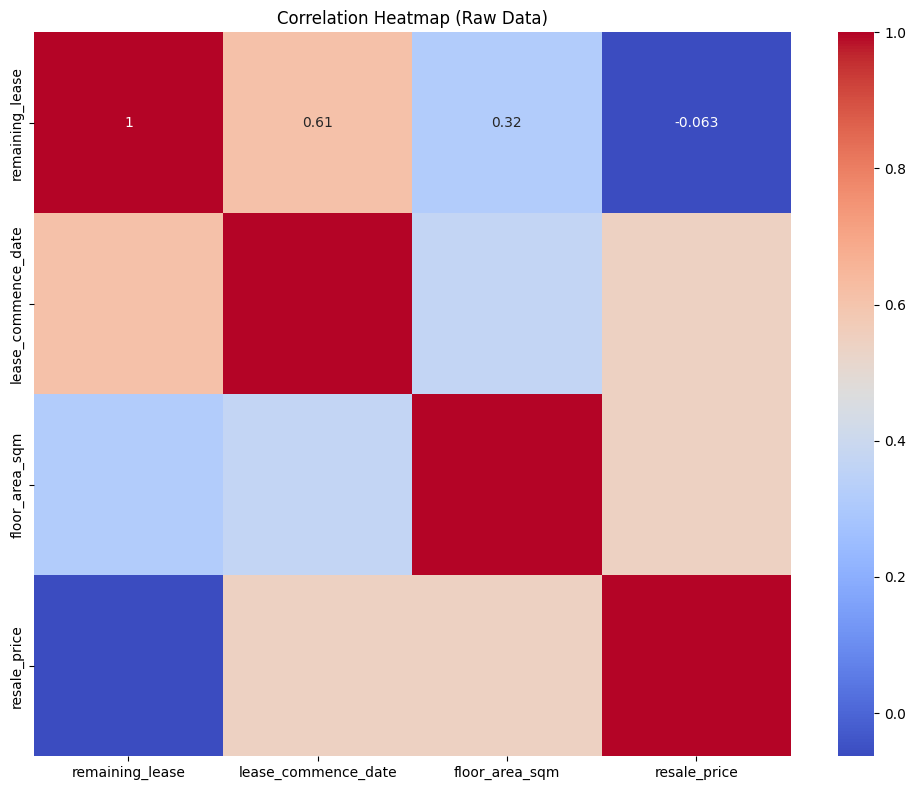

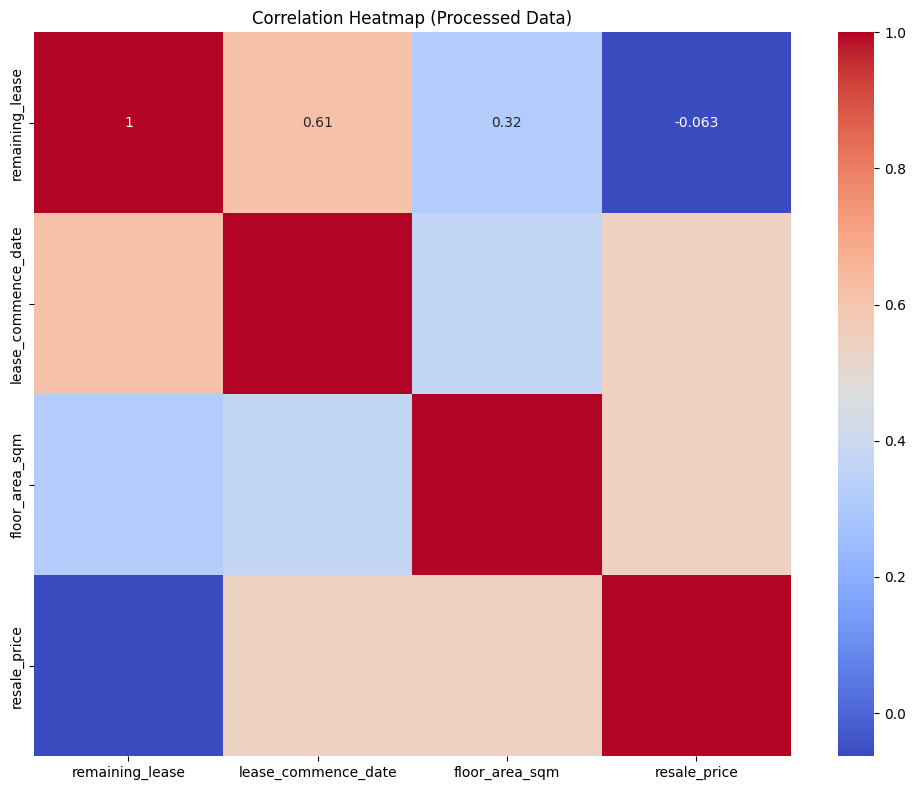

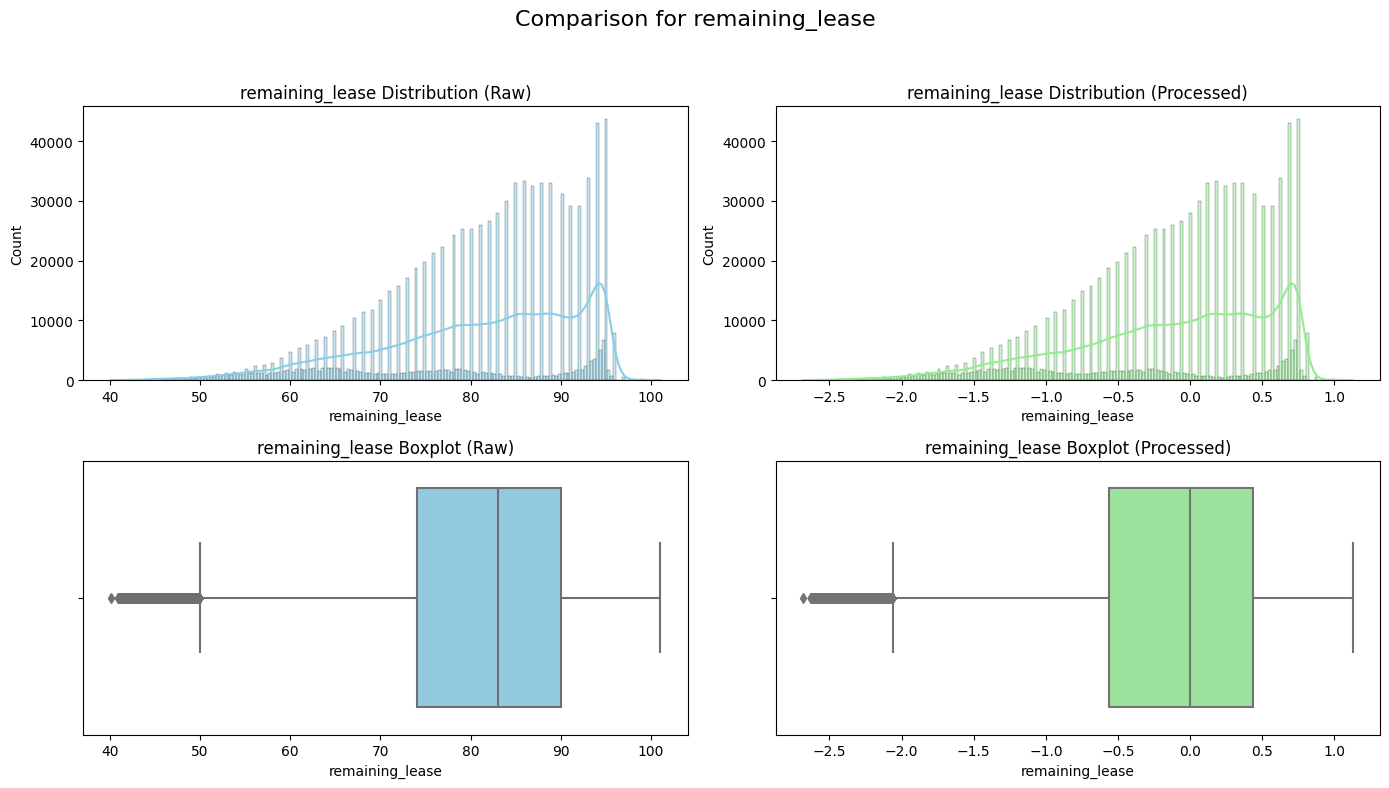

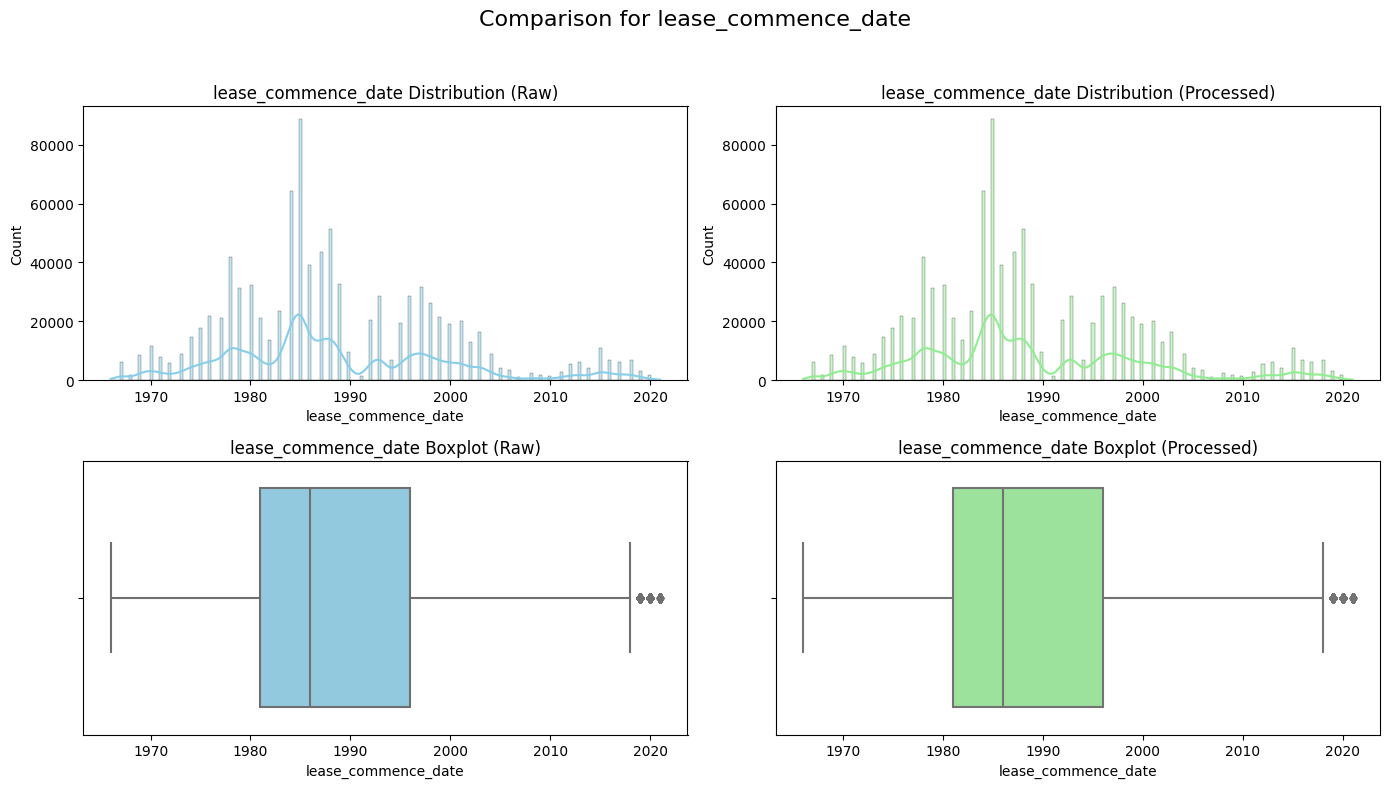

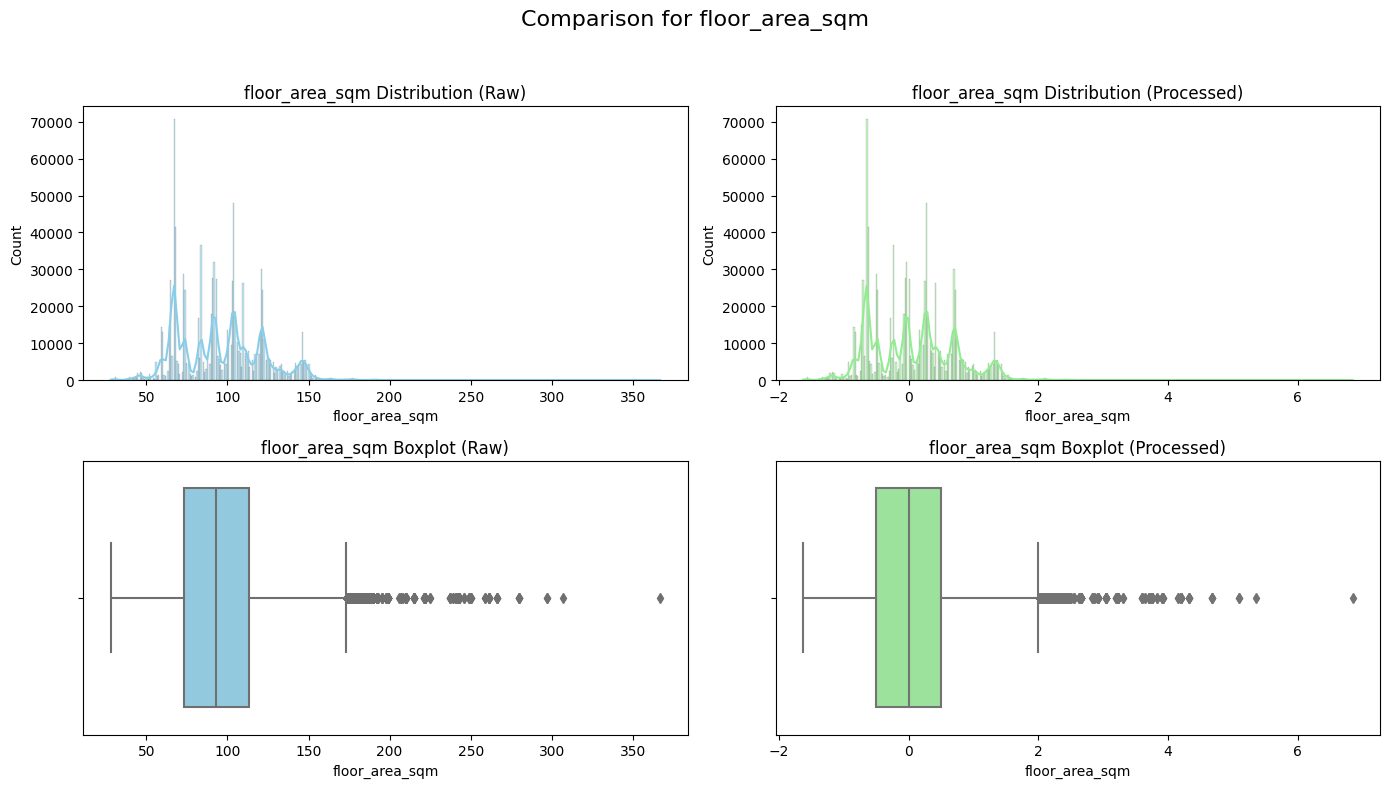

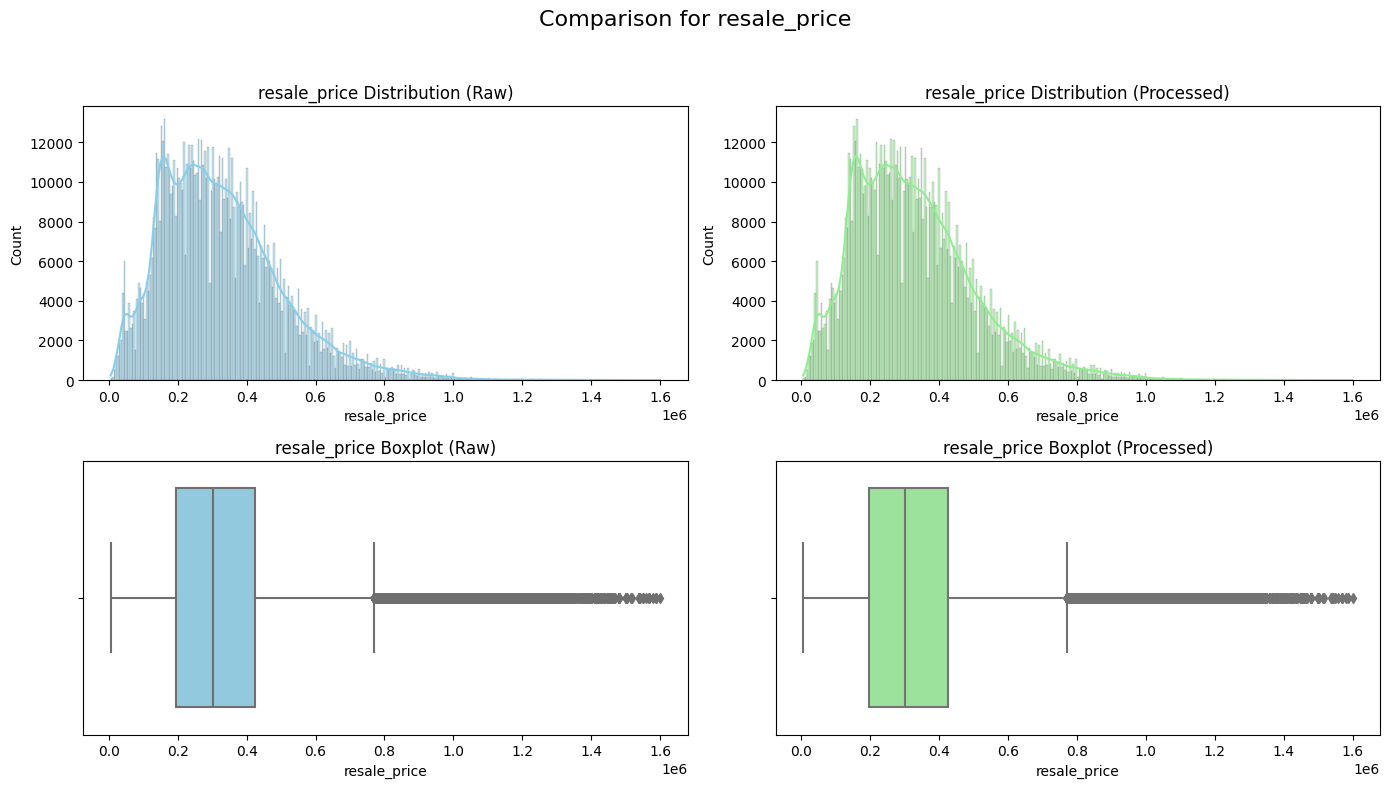

In [9]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_numerical_data(df, title="Data Analysis"):
    """
    Prints a detailed analysis for numeric columns:
      - Shape and list of numeric columns
      - Summary statistics (mean, std, min, 25%, 50%, 75%, max)
      - Unique value counts per column
      - Correlation matrix for numeric columns
    """
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    print(f"=== {title} ===")
    print("Data Shape:", df.shape)
    print("\nNumeric Columns:", numeric_cols)
    print("\nSummary Statistics for Numeric Columns:")
    print(df[numeric_cols].describe())
    print("\nUnique Value Counts for Numeric Columns:")
    for col in numeric_cols:
        print(f"{col}: {df[col].nunique()} unique values")
    print("\nCorrelation Matrix for Numeric Columns:")
    print(df[numeric_cols].corr())
    print("\n" + "="*80 + "\n")

def create_summary_table(df, label="Raw"):
    """
    Creates a summary DataFrame for numeric columns in the given DataFrame.
    The summary includes descriptive statistics and unique counts.
    """
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    summary = df[numeric_cols].describe().T
    summary["unique"] = df[numeric_cols].nunique()
    summary["source"] = label
    return summary

def compare_common_numeric(raw_df, proc_df):
    """
    Compares common numeric columns between raw and processed DataFrames.
    Prints a side-by-side table of descriptive statistics for each common column.
    Also creates correlation heatmaps for both datasets.
    """
    # Identify common numeric columns between the two datasets
    raw_numeric = set(raw_df.select_dtypes(include=["int64", "float64"]).columns.tolist())
    proc_numeric = set(proc_df.select_dtypes(include=["int64", "float64"]).columns.tolist())
    common_cols = list(raw_numeric.intersection(proc_numeric))
    
    if not common_cols:
        print("No common numeric columns found between raw and processed data.")
        return

    # Create summary tables for common columns
    raw_summary = raw_df[common_cols].describe().T
    raw_summary["unique"] = raw_df[common_cols].nunique()
    proc_summary = proc_df[common_cols].describe().T
    proc_summary["unique"] = proc_df[common_cols].nunique()
    
    # Concatenate summaries side-by-side
    comparison_table = pd.concat([raw_summary.add_suffix(" (Raw)"), 
                                  proc_summary.add_suffix(" (Processed)")], axis=1)
    
    print("=== Comparison of Common Numeric Columns ===")
    print(comparison_table)
    
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(raw_df[list(common_cols)].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap (Raw Data)")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(proc_df[list(common_cols)].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap (Processed Data)")
    plt.tight_layout()
    plt.show()
    
    # Plot distribution comparisons for each common column
    plot_distribution_comparison(raw_df, proc_df, common_cols)
    
def plot_distribution_comparison(raw_df, proc_df, columns):
    """
    For each column in 'columns', plots side-by-side histograms and boxplots 
    to visually compare distributions between raw and processed data.
    """
    for col in columns:
        fig, axes = plt.subplots(2, 2, figsize=(14, 8))
        # Histograms
        sns.histplot(raw_df[col].dropna(), kde=True, ax=axes[0,0], color='skyblue')
        axes[0,0].set_title(f"{col} Distribution (Raw)")
        sns.histplot(proc_df[col].dropna(), kde=True, ax=axes[0,1], color='lightgreen')
        axes[0,1].set_title(f"{col} Distribution (Processed)")
        
        # Boxplots
        sns.boxplot(x=raw_df[col].dropna(), ax=axes[1,0], color='skyblue')
        axes[1,0].set_title(f"{col} Boxplot (Raw)")
        sns.boxplot(x=proc_df[col].dropna(), ax=axes[1,1], color='lightgreen')
        axes[1,1].set_title(f"{col} Boxplot (Processed)")
        
        plt.suptitle(f"Comparison for {col}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# --- Analysis for Raw Merged Data ---
raw_df = pd.read_csv("merged_data.csv")
analyze_numerical_data(raw_df, "Raw Merged Data Analysis")
raw_summary_table = create_summary_table(raw_df, label="Raw")

# --- Analysis for Processed Data ---
proc_df = pd.read_csv("processed_data.csv")
analyze_numerical_data(proc_df, "Processed Data Analysis")
proc_summary_table = create_summary_table(proc_df, label="Processed")

# --- Compare Common Numeric Columns Between Raw and Processed Data ---
compare_common_numeric(raw_df, proc_df)


Split train_25:
X_train shape: (237240, 26)
X_test shape: (711722, 26)
y_train shape: (237240,)
y_test shape: (711722,)


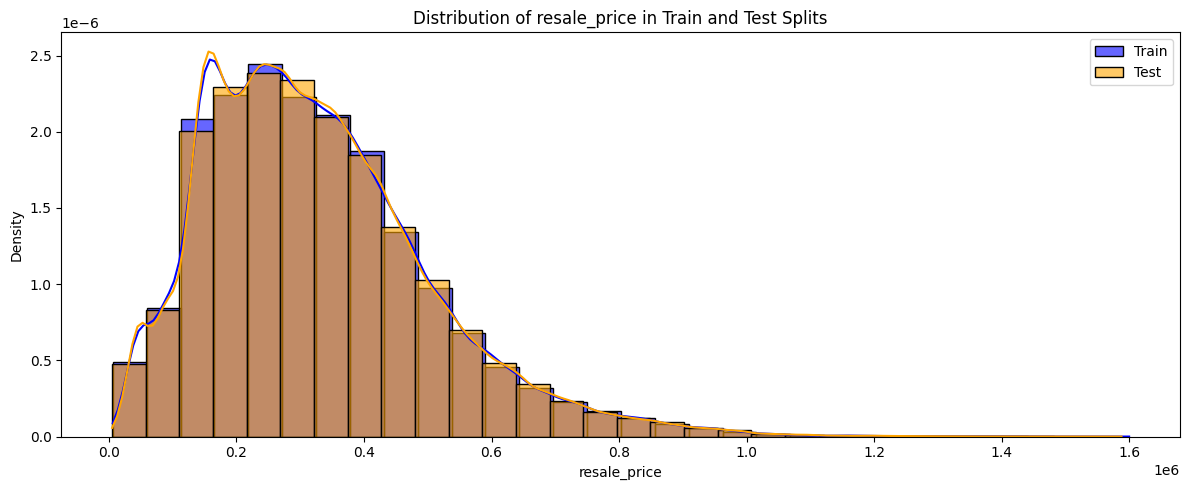

Split train_50:
X_train shape: (474481, 26)
X_test shape: (474481, 26)
y_train shape: (474481,)
y_test shape: (474481,)


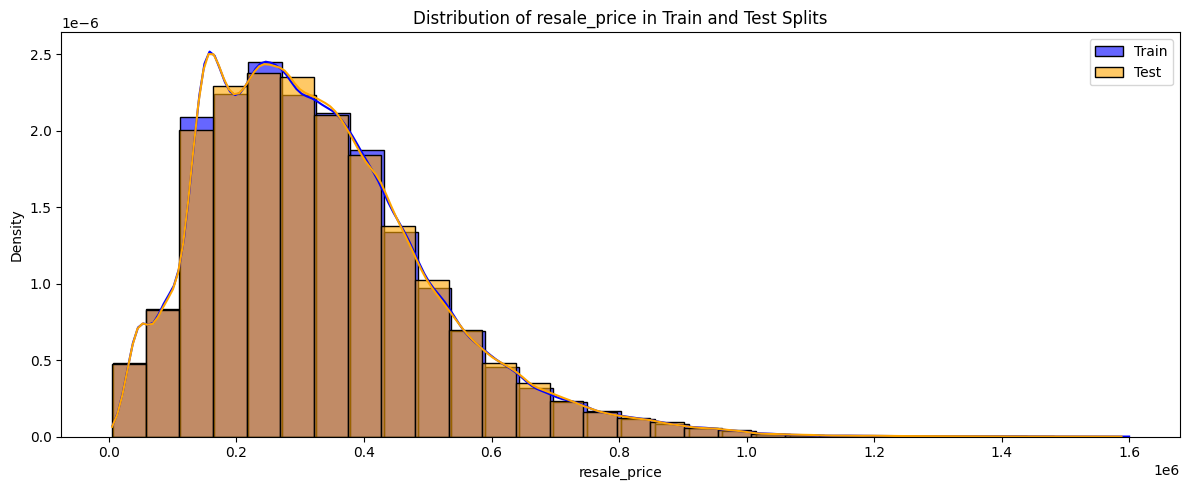

Split train_75:
X_train shape: (711721, 26)
X_test shape: (237241, 26)
y_train shape: (711721,)
y_test shape: (237241,)


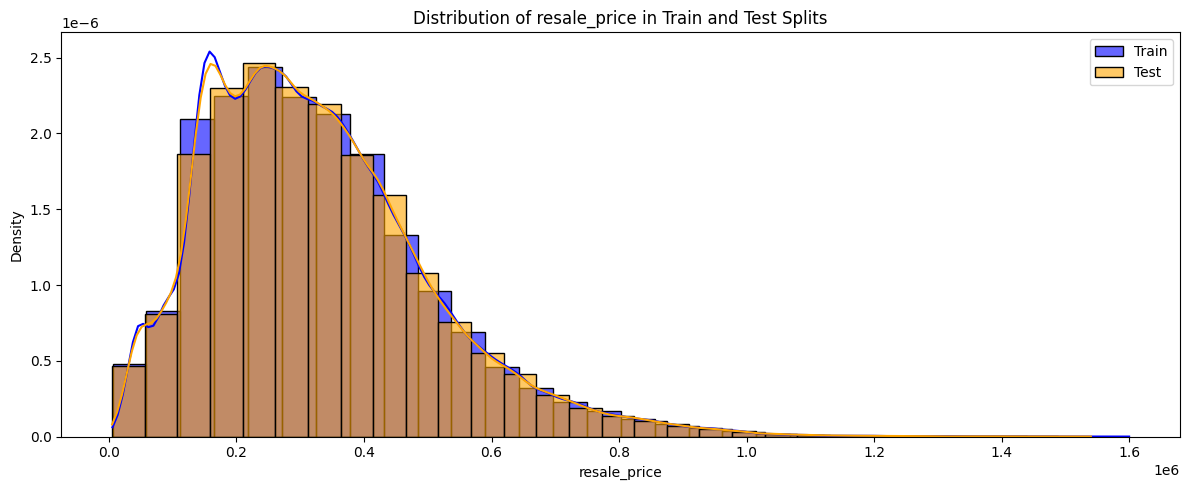

In [10]:
from sklearn.model_selection import train_test_split


def get_predefined_splits(file_path, target_column, split_ratios=[0.25, 0.50, 0.75], random_state=42):
    """
    Loads a processed dataset from file_path and returns a dictionary with predefined data splits.
    
    Parameters:
        file_path (str): Path to the processed CSV file.
        target_column (str): Name of the target column.
        split_ratios (list): List of fractions for the training set (e.g., [0.25, 0.50, 0.75]).
        random_state (int): Fixed seed for reproducibility.
    
    Returns:
        dict: Dictionary where each key is like "train_25" and the value is a tuple
              (X_train, X_test, y_train, y_test).
    """
    df = pd.read_csv(file_path)
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    splits = {}
    for ratio in split_ratios:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=ratio, random_state=random_state)
        splits[f"train_{int(ratio*100)}"] = (X_train, X_test, y_train, y_test)
    return splits

def plot_target_distribution(y_train, y_test, target_column):
    """
    Plots side-by-side histograms (with KDE) of the target variable for the training and testing sets.
    
    Parameters:
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.
        target_column (str): Name of the target variable (for title purposes).
    """
    plt.figure(figsize=(12, 5))
    sns.histplot(y_train.dropna(), kde=True, color="blue", label="Train", stat="density", bins=30, alpha=0.6)
    sns.histplot(y_test.dropna(), kde=True, color="orange", label="Test", stat="density", bins=30, alpha=0.6)
    plt.title(f"Distribution of {target_column} in Train and Test Splits")
    plt.xlabel(target_column)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# For testing the module independently:
if __name__ == "__main__":
    file_path = "processed_data.csv"
    target_column = "resale_price"
    splits = get_predefined_splits(file_path, target_column)
    
    for key, (X_train, X_test, y_train, y_test) in splits.items():
        print(f"Split {key}:")
        print("X_train shape:", X_train.shape)
        print("X_test shape:", X_test.shape)
        print("y_train shape:", y_train.shape)
        print("y_test shape:", y_test.shape)
        # Plot the distribution of the target variable for each split
        plot_target_distribution(y_train, y_test, target_column)